# Cleantech RAG

By [Daniel Perruchoud](https://www.linkedin.com/in/daniel-olivier-perruchoud-799aaa38/) and [George Rowlands](https://www.linkedin.com/in/georgerowlands/)

## Introduction

This notebook delves into the exciting realm of Cleantech using a [dataset of nearly 10,000 news articles from Kaggle](https://www.kaggle.com/datasets/jannalipenkova/cleantech-media-dataset), all centered around the energy sector. We'll embark on a journey that includes data exploration, text preprocessing, and culminates in the creation of a Retrieval-Augmented Generation Pipeline (RAG). This powerful approach empowers us to construct an LLM (Large Language Model) that can intelligently answer user queries, drawing upon the knowledge from our curated news articles.

### Why RAG? A Cost-Effective and Dynamic Solution

Fine-tuning an LLM can be a resource-intensive and inflexible process. RAG offers a compelling alternative. It leverages a semantic search to pinpoint relevant sections within our news articles that directly address a user's question. These retrieved sections are then provided to the LLM as context, enabling it to deliver informed and insightful responses.

![rag_pipline](https://arxiv.org/html/2312.10997v5/extracted/2312.10997v5/images/RAG_case.png)

### Setup

To run this notebook we recommend downloading the provided [GitHub repository](https://github.com/LuciferUchiha/Cleantech-RAG) and opening this notebook in [Google Colab](https://colab.research.google.com/). To ensure a smooth experience, you'll need:

- An OpenAI API key for GPT-4o
- A Google account for Google Colab
- Python packages (automatically installed within the notebook)

At the start of the notebook a `data.zip` will be downloaded from a Google Drive and unzipped. This will then provide you with files that contain checkpoints for all of the expensive processing sections such as chunking, generating embeddings and evaluating the pipeline with an LLM as a judge. This saves you money and a lot of time.

If you can't or don't want to run this notebook you can also view the completed notebook by opening the `cleantech_rag.html` file in your browser.

### Unveiling the Depths of RAG Pipelines

Throughout this notebook, we'll delve into the intricate workings of RAG pipelines. Prepare to explore:

- Building a Robust RAG Pipeline:
  - LLM: GPT-4o
  - Semantic Search: ChromaDB with HNSW for fast retrieval
  - Embedding Models: Alibaba, BGE-M3, all-MiniLM-L6-v2
  - Chunking Strategies: Recursive (256 & 1024 chunk sizes) and Semantic Chunking
- Understanding RAG's Inner Workings:
  - Examining the embedding space of news articles
  - Demystifying the semantic search process
- Visualization and Explanation:
  - Visualizing the impact of advanced strategies like HyDE and Multi-querying
- Evaluation and Comparison:
  - RAGAS for LLM-based evaluation
  - Traditional retrieval metrics

Questions or Issues? We're Here to Help!

If you encounter any roadblocks or have questions, please don't hesitate to reach out to [George Rowlands](https://www.linkedin.com/in/georgerowlands/)

## Setting your OpenAI Key

This OpenAI Key is used for the following tasks:
- Generating embeddings for our semantic search.
- Leveraging GPT-4-turbo as our LLM in our RAG pipeline and as our judge in RAGAS.

In [ ]:
%%writefile .env

OPENAI_API_KEY=''

Writing .env


After executing the above cell, you should restart the kernel/runtime to ensure the key is properly set.

## Installing Dependencies

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
%%writefile requirements.txt

chromadb==0.5.0
datasets==2.19.1
gdown==5.2.0
kaggle==1.6.1
langchain==0.3.10
langchain-community==0.3.10
langchain-experimental==0.3.3
langchain-openai==0.2.12
langdetect==1.0.9
lorem-text==2.1
nbformat>=4.2.0
openai==1.57.1
plotly==5.22.0
pretty-jupyter==1.0
ragas==0.1.8
seaborn==0.13.2
sentence-transformers==3.0.0
spacy>=3.7
textstat==0.7.3
umap-learn==0.5.5

Writing requirements.txt


In [ ]:
%pip install torch==2.5.1 --quiet --index-url https://download.pytorch.org/whl/cu121

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 126.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 4.7 MB/s eta 0:00:00
ERROR: pip's dependency resol

In [ ]:
%pip install -r ./requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install --upgrade fsspec==2025.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.3.1
    Uninstalling fsspec-2024.3.1:
      Successfully uninstalled fsspec-2024.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.19.1 requires fsspec[http]<=2024.3.1,>=2023.1.0, but you have fsspec 2025.3.0 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.5.1+cu121 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.5.1+cu121 which is incompatible.


In [ ]:
!pip check

datasets 2.19.1 has requirement fsspec[http]<=2024.3.1,>=2023.1.0, but you have fsspec 2025.3.0.
gcsfs 2025.3.2 has requirement fsspec==2025.3.2, but you have fsspec 2025.3.0.
torchaudio 2.6.0+cu124 has requirement torch==2.6.0, but you have torch 2.5.1+cu121.
torchvision 0.21.0+cu124 has requirement torch==2.6.0, but you have torch 2.5.1+cu121.


In [ ]:
!pip install --upgrade --force-reinstall gcsfs fsspec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.9/174.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
!pip uninstall torch torchvision -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.7.0%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.22.0%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cuda_nvrtc_cu11-11.8.89-py3-none-manylinux1_x86_64.whl (23.2 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cuda_runtime_cu11-11.8.89-py3-none-manylinux1_x86_64.whl (875 kB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cuda_cupti_cu11-11.8.87-py3-none-manylinux1_x86_64.whl (13.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import json
import os
import warnings
import zipfile
from collections import Counter
from pathlib import Path
from typing import Dict, List

import chromadb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import torch
from chromadb import Collection, Documents, EmbeddingFunction, Embeddings
from datasets import Dataset
from dotenv import load_dotenv
from langdetect import detect
from lorem_text import lorem
from ragas import RunConfig, evaluate
from ragas.metrics import (faithfulness, answer_relevancy, context_relevancy, answer_correctness)
from spacy.lang.en import English
from textstat import flesch_reading_ease
from tqdm import tqdm
import umap

/usr/local/lib/python3.11/dist-packages/ragas/metrics/__init__.py:1: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from ragas.metrics._answer_correctness import AnswerCorrectness, answer_correctness
/usr/local/lib/python3.11/dist-packages/ragas/metrics/__init__.py:4: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to impo

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [ ]:
import umap
from langchain.chains.base import Chain
from langchain.text_splitter import RecursiveCharacterTextSplitter, TextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma, VectorStore
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.language_models import LLM
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.retrievers import BaseRetriever
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

load_dotenv()
warnings.filterwarnings("ignore")

By removing the first line from the two cells below, you can download the dataset, chunks, embeddings of the chunks and evaluation results from our Google Drive. This will save you time and money.

In [ ]:
%%script echo skipping
!gdown 1VmFQFogA4S7iy5iX2-Tsl3xa11zNnUFR

skipping


In [ ]:
%%script echo skipping
with zipfile.ZipFile("data.zip", "r") as zip_file:
    zip_file.extractall()

skipping


### Setting up our LLM

To make sure our OpenAI Key is working we will test it by generating a response from GPT-4o which we will later on also be using in our RAG pipeline. Try some different prompts or questions to see how the model responds.

In [ ]:
llm = ChatOpenAI(model="gpt-4o")
question_prompt = ChatPromptTemplate.from_template(
    "Answer the following question: {question}")
question_chain = question_prompt | llm | StrOutputParser()
question_chain.invoke({"question": "What is the meaning of life?"})

'The question of the meaning of life has been a central topic of philosophy, religion, and science for centuries, and there is no single, universally accepted answer. Different perspectives offer various interpretations:\n\n1. **Philosophical Perspectives**:\n   - **Existentialism**: Suggests that life has no inherent meaning, and it is up to individuals to create their own meaning through their choices and actions.\n   - **Nihilism**: Argues that life is without objective meaning, purpose, or intrinsic value.\n   - **Absurdism**: Proposes that humans naturally seek meaning, but the universe is indifferent, leading to an inherent conflict or "absurdity."\n\n2. **Religious and Spiritual Perspectives**:\n   - Many religions propose that the meaning of life is connected to a relationship with a higher power, spiritual growth, or an afterlife.\n   - For example, Christianity often sees life\'s purpose as living in accordance with God\'s will and achieving eternal life through faith and goo

## Downloading the Dataset from Kaggle

We will be exploring the following [Cleantech Media Dataset](https://www.kaggle.com/datasets/jannalipenkova/cleantech-media-dataset). If you have opened this notebook as recommended by opening the provided Github repository in Google Colab then you don't need to to download the dataset. It should already be under `data/bronze`. If not then you can either manually download it and upload it into a `data/bronze` folder or follow the steps below.

### Using the Kaggle API

We will be using the [Kaggle API](https://github.com/Kaggle/kaggle-api) to download the data.

To use the Kaggle API you will need a Kaggle account. If you don't already have one, sign up for a Kaggle account at https://www.kaggle.com. When you are logged in, go to the 'Settings' tab of your user profile `https://www.kaggle.com/settings` and select 'Create New Token'. This will trigger the download of `kaggle.json`, a file containing your API credentials.

You can then add your Kaggle username and key from the `kaggle.json`.

In [ ]:
data_folder = Path("data")
if not data_folder.exists():
    data_folder.mkdir()
bronze_folder = data_folder / "bronze"
if not bronze_folder.exists():
    bronze_folder.mkdir()

In [ ]:
from google.colab import files
files.upload()  # Manually upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tamanna507","key":"846aefb30a72d5ed54dd954cf97074c9"}'}

In [ ]:
import os
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions


In [ ]:
# %%script echo skipping
!kaggle datasets download -d jannalipenkova/cleantech-media-dataset -p {bronze_folder} --unzip

 78% 25.0M/31.9M [00:00<00:00, 89.3MB/s]
100% 31.9M/31.9M [00:00<00:00, 73.0MB/s]


In [ ]:
!kaggle datasets download -d prakharbhandari20/cleantech-google-patent-dataset -p {bronze_folder} --unzip

 93% 111M/120M [00:01<00:00, 128MB/s] 
100% 120M/120M [00:01<00:00, 104MB/s]


## Loading the Dataset into Dataframes

We now load and inspect both the Cleantech Media Dataset and the gold-standard evaluation data provided by our subject matter expert, Janna Lipenkova.

In [ ]:
articles_df = pd.read_csv(
    bronze_folder / "cleantech_media_dataset_v3_2024-10-28.csv",
    encoding='utf-8', index_col=0, on_bad_lines='skip')
articles_df.head()

,title,date,author,content,domain,url
93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,NaN,['Chinese automotive startup XPeng has shown o...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-del...
93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,NaN,['Sinopec has laid plans to build the largest ...,cleantechnica,https://cleantechnica.com/2022/01/02/its-a-gre...
98159,World’ s largest floating PV plant goes online...,2022-01-03,NaN,['Huaneng Power International has switched on ...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-...
98158,Iran wants to deploy 10 GW of renewables over ...,2022-01-03,NaN,"['According to the Iranian authorities, there ...",pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wa...
31128,Eastern Interconnection Power Grid Said ‘ Bein...,2022-01-03,NaN,['Sign in to get the best natural gas news and...,naturalgasintel,https://www.naturalgasintel.com/eastern-interc...


In [ ]:
patents_df = pd.read_json(bronze_folder /"CleanTech_22-24_updated.json", lines=True)
patents_df.head(5)

,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc_code
0,CN-117138249-A,CN-202311356270-A,CN,一种石墨烯光疗面罩,The application provides a graphene photothera...,20231201,"[LI HAITAO, CAO WENQIANG]",A61N2005/0654
1,CN-117151396-A,CN-202311109834-A,CN,Distributed economic scheduling method for win...,The invention discloses a distributed economic...,20231201,"[HU PENGFEI, LI ZIMENG]",G06Q50/06
2,CN-117141530-A,CN-202310980795-A,CN,氢能源动力轨道车辆组,The invention discloses a hydrogen energy powe...,20231201,"[XIE BO, ZHANG SHUIQING, ZHOU FEI, LIU YONG, Z...",Y02T90/40
3,CN-117141244-A,CN-202311177651-A,CN,一种汽车太阳能充电系统、方法及新能源汽车,The application discloses an automobile solar ...,20231201,[ZHAO PENGCHENG],B60K16/00
4,CN-117146094-A,CN-202311272549-A,CN,一种水利水电管道连接装置,The invention provides a water conservancy and...,20231201,"[LYU SHUOSHUO, LI PANFENG, XU ZHENGWEI, WANG W...",F16L55/02


In [ ]:
# Keep only one row for each `publication_number`, ignoring differences in `cpc_code` or `inventor`
print(f"Number of rows before: {len(patents_df)}")
patents_df_unique = patents_df.drop_duplicates(subset=["publication_number","application_number","country_code", "title", "abstract", "publication_date"])
print(f"Number of rows after: {len(patents_df_unique)}")

Number of rows before: 406857
Number of rows after: 68125


In [ ]:
publication_number_counts = patents_df_unique.groupby('publication_number').size().sort_values(ascending=False)
print(publication_number_counts)

publication_number
WO-2024027062-A1    10
WO-2024131301-A1    10
WO-2022183304-A1    10
EP-4052298-A1        8
WO-2022265333-A1     7
                    ..
US-11828147-B2       1
US-11828138-B2       1
US-11824484-B2       1
US-11824363-B2       1
ZA-202309063-B       1
Length: 31366, dtype: int64


In [ ]:
patents_df_unique[patents_df_unique['publication_number'] == 'ZA-202309063-B']

,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc_code
2390,ZA-202309063-B,ZA-202309063-A,ZA,A fish-passing system and a fish-passing metho...,This invention discloses a fish-passing system...,20231129,"[JIAFEI ZHOU, TENGFEI TANG, FAN CHEN, ZAIXING ...",Y02A40/60


In [18]:
# patents_df_unique.to_csv(bronze_folder / "cleantech_patents_with_lang.csv", index=False)
output_path = bronze_folder / "cleantech_patents_with_lang.csv"

if output_path.exists():
    patents_df_unique = pd.read_csv(output_path)
else:
    print("dataset not found. Running language detection...")

    # Detect language of title and abstract
    patents_df_unique["title_lang"] = patents_df_unique["title"].apply(detect)
    patents_df_unique["abstract_lang"] = patents_df_unique["abstract"].apply(detect)

    # Save full dataset
    patents_df_unique.to_csv(output_path, index=False)
    print(f"Saved full dataset with language detection: {output_path.name}")

# Filter only English rows
patents_df_unique_en = patents_df_unique[
    (patents_df_unique["title_lang"] == "en") &
    (patents_df_unique["abstract_lang"] == "en")
]


dataset not found. Running language detection...
Saved full dataset with language detection: cleantech_patents_with_lang.csv


In [19]:
patents_df_unique_en.head(5)

,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc_code,title_lang,abstract_lang
1,CN-117151396-A,CN-202311109834-A,CN,Distributed economic scheduling method for win...,The invention discloses a distributed economic...,20231201,"[HU PENGFEI, LI ZIMENG]",G06Q50/06,en,en
5,CN-117147382-A,CN-202310985511-A,CN,Device for monitoring hydrogen atom crossing g...,The invention provides a device and a method f...,20231201,"[MA ZHAOXIANG, WANG CHENGXU, LIU ZHONGLI]",G01N13/00,en,en
6,CN-113344288-B,CN-202110717505-A,CN,Cascade hydropower station group water level p...,The invention discloses a cascade hydropower s...,20231201,[],G06Q10/04,en,en
8,CN-117153944-A,CN-202311209193-A,CN,"Heterojunction solar cell, preparation method ...",The application provides a heterojunction sola...,20231201,"[TONG HONGBO, JIN YUPENG]",H01L31/074,en,en
9,CN-116911695-B,CN-202311167289-A,CN,Flexible resource adequacy evaluation method a...,The invention relates to a flexible resource a...,20231201,[],H02J2203/20,en,en


In [20]:
human_eval_df = pd.read_csv(
    bronze_folder / "cleantech_rag_evaluation_data_2024-09-20.csv",
    encoding='utf-8',
    # index_col=0,
    sep=';')
human_eval_df.head()

,example_id,question_id,question,relevant_text,answer,article_url
0,1,1,What is the innovation behind Leclanché's new ...,Leclanché said it has developed an environment...,Leclanché's innovation is using a water-based ...,https://www.sgvoice.net/strategy/technology/23...
1,2,2,What is the EU’s Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the...,The EU’s Green Deal Industrial Plan aims to en...,https://www.sgvoice.net/policy/25396/eu-seeks-...
2,3,2,What is the EU’s Green Deal Industrial Plan?,The European counterpart to the US Inflation R...,The EU’s Green Deal Industrial Plan aims to en...,https://www.pv-magazine.com/2023/02/02/europea...
3,4,3,What are the four focus areas of the EU's Gree...,The new plan is fundamentally focused on four ...,The four focus areas of the EU's Green Deal In...,https://www.sgvoice.net/policy/25396/eu-seeks-...
4,5,4,When did the cooperation between GM and Honda ...,What caught our eye was a new hookup between G...,July 2013,https://cleantechnica.com/2023/05/08/general-m...


In [21]:
human_eval_df_media_cleaned = pd.read_csv(
    bronze_folder / "generated_questions_cleaned_media_llama.csv",
    encoding='utf-8',
    # index_col=0,
    # sep=';'
    )
human_eval_df_media_cleaned.head()

,Unnamed: 0,context,question,answer,source_doc,category,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
0,0,"As we move toward a sustainable future, green ...","What is green hydrogen, and how is it produced?",Green hydrogen is a sustainable energy carrier...,https://www.azocleantech.com/article.aspx?Arti...,Sustainability & Technological Innovation Ques...,5.0,The provided context clearly explains what gre...,3.0,"The question is straightforward and clear, inq...",5.0,The question is self-explanatory and does not ...
1,5,"As we move toward a sustainable future, green ...",What is the significance of the Neom project i...,"The Neom project, a partnership between ACWA P...",https://www.azocleantech.com/article.aspx?Arti...,Sustainability & Technological Innovation Ques...,5.0,The context provides a comprehensive overview ...,4.0,The Neom project is a key concept in the conte...,4.0,The question appears to rely on additional kno...
2,8,"As we move toward a sustainable future, green ...",What is the significance of the Energy Transit...,The report highlights the need for a 30-year t...,https://www.azocleantech.com/article.aspx?Arti...,Sustainability & Technological Innovation Ques...,5.0,The question regarding the significance of the...,3.0,This question appears to be relevant to enviro...,5.0,The question refers to a specific institution ...
3,10,"As we move toward a sustainable future, green ...",How does green hydrogen compare to direct use ...,Green hydrogen production through electrolysis...,https://www.azocleantech.com/article.aspx?Arti...,Sustainability & Technological Innovation Ques...,4.0,The question requires an in-depth analysis of ...,4.0,This question is relevant to NLP developers bu...,5.0,The question implies that there might be some ...
4,14,"As we move toward a sustainable future, green ...",What are some of the examples of pilot project...,Various pilot projects are testing green hydro...,https://www.azocleantech.com/article.aspx?Arti...,Sustainability & Technological Innovation Ques...,5.0,The question can be answered unambiguously bas...,3.0,This question appears to be focused on environ...,4.0,The question asks for specific examples of pil...


In [22]:
human_eval_df_patent_cleaned = pd.read_csv(
    bronze_folder / "generated_questions_cleaned_patent_llama.csv",
    encoding='utf-8',
    # index_col=0,
    # sep=';',
    on_bad_lines='skip' # or 'error'
)
human_eval_df_patent_cleaned.head()

,Unnamed: 0,context,question,answer,category,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
0,5,Distributed photovoltaic energy storage refrig...,How does the system reduce the cost of cold st...,The system reduces the cost of cold storage by...,Sustainability & Technological Innovation Ques...,5.0,The question can be answered based on the give...,4.0,"The question is concise and to the point, dire...",5.0,The question appears to be related to a genera...
1,10,Water path manifold structure of hydrogen ener...,What is good about the utility model?,The utility model has a simple structure that ...,Analytical & Explanatory Questions,5.0,"The question ""What is good about the utility m...",3.0,"The question is very short and to the point, b...",5.0,The question seems to be asking about a genera...
2,29,Active power control method of water-fire-wind...,What is the purpose of using power supply with...,The power supply with better regulation perfor...,Government & Corporate Initiatives,5.0,The question is clearly answerable by understa...,3.0,The question is directly related to power supp...,5.0,The question assumes knowledge of power suppli...
3,48,Water conservancy and hydropower engineering c...,What is the water conservancy and hydropower e...,The utility model discloses a water conservanc...,Sustainability & Technological Innovation Ques...,5.0,The question is clearly answerable with the gi...,3.0,The question seems to be about a specific tech...,5.0,The question contains technical terms and a sp...
4,61,Medium-and-long-term electric power quantity b...,What is the main consideration for the balanci...,The seasonal characteristics of renewable ener...,Analytical & Explanatory Questions,4.0,The context provides a detailed description of...,4.0,The question is asking about a specific aspect...,5.0,The question does not provide a specific conte...


In [23]:
human_eval_df_media = pd.read_csv(
    bronze_folder / "QA_pairs_categorized_media_qa_df_llama.csv",
    encoding='utf-8',
    # index_col=0,
    # sep=';'
    )

human_eval_df_media.head()

,Unnamed: 0,question,relevant_text,answer,article_url,category
0,0,"What is green hydrogen, and how is it produced?","As we move toward a sustainable future, green ...",Green hydrogen is a sustainable energy carrier...,https://www.azocleantech.com/article.aspx?Arti...,Sustainability & Technological Innovation Ques...
1,1,Who are some of the key players involved in th...,"As we move toward a sustainable future, green ...",Key players include companies like Siemens Ene...,https://www.azocleantech.com/article.aspx?Arti...,Sustainability & Technological Innovation Ques...
2,2,What are the main challenges associated with i...,"As we move toward a sustainable future, green ...",The main challenges include technical hurdles ...,https://www.azocleantech.com/article.aspx?Arti...,Sustainability & Technological Innovation Ques...
3,3,What is the role of the European Union's Hydro...,"As we move toward a sustainable future, green ...",The strategy aims to significantly ramp up gre...,https://www.azocleantech.com/article.aspx?Arti...,Sustainability & Technological Innovation Ques...
4,4,How does the Hydrogen Council facilitate partn...,"As we move toward a sustainable future, green ...",The Hydrogen Council brings together over 80 e...,https://www.azocleantech.com/article.aspx?Arti...,Government & Corporate Initiatives


In [24]:
human_eval_df_patent = pd.read_csv(
    bronze_folder / "QA_pairs_categorized_patent_qa_df_llama.csv",
    encoding='utf-8',
    # index_col=0,
    # sep=';'
    )
human_eval_df_patent.head()

,Unnamed: 0,question,answer,relevant_text,title,publication_date,inventor,category
0,0,What is the purpose of the cold accumulator ev...,"To supply cold to the cold storage, reducing t...",Distributed photovoltaic energy storage refrig...,Distributed photovoltaic energy storage refrig...,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Analytical & Explanatory Questions
1,1,What is the role of the refrigeration house co...,It is connected with the cold accumulation com...,Distributed photovoltaic energy storage refrig...,Distributed photovoltaic energy storage refrig...,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Government & Corporate Initiatives
2,2,What is the overall function of the distribute...,To convert solar energy into electric energy t...,Distributed photovoltaic energy storage refrig...,Distributed photovoltaic energy storage refrig...,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Sustainability & Technological Innovation Ques...
3,3,What is the purpose of the distributed photovo...,"The system supplies cold to the cold storage, ...",Distributed photovoltaic energy storage refrig...,Distributed photovoltaic energy storage refrig...,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Sustainability & Technological Innovation Ques...
4,4,What is the main function of the cold accumula...,The cold accumulation equipment stores cold en...,Distributed photovoltaic energy storage refrig...,Distributed photovoltaic energy storage refrig...,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Sustainability & Technological Innovation Ques...


## Explorative Data Analysis & Preprocessing

As the saying goes, "garbage in, garbage out."  In the realm of machine learning, the quality of our outputs hinges on the quality of our inputs.  This section delves into the essential processes of Exploratory Data Analysis (EDA) and data preprocessing. Through EDA, we'll illuminate the characteristics, patterns, and potential quirks residing within our cleantech news article dataset. Preprocessing will ensure our data is cleansed, structured, and prepared to be effectively utilized by the RAG pipeline, laying the foundation for high-quality results.

Let us start by gaining an overview of the datasets features (columns).

#### Media Datset

In [25]:
articles_df.describe()

,author
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [26]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20111 entries, 93320 to 101431
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   title    20111 non-null  object 
 1   date     20111 non-null  object 
 2   author   0 non-null      float64
 3   content  20111 non-null  object 
 4   domain   20111 non-null  object 
 5   url      20111 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.6+ MB


Our initial exploration reveals that the "author" column only contains data for 31 out of 9593 articles. Since this offers minimal information gain, we can remove this feature.

We've also observed that some titles and content entries appear to be non-unique. This might necessitate identifying and removing duplicate entries.

On a positive note, the article URLs are all unique, potentially serving as suitable unique identifiers for the data.

In [27]:
articles_df = articles_df.drop(columns=["author"])

### Article Domains

The dataset helpfully provides the domain names extracted from the article URLs. These domains essentially represent the publishers of the news articles. Let's analyze the distribution of publishers and see how many articles each publisher has contributed.

In [28]:
domain_counts = articles_df["domain"].value_counts()
domain_counts

,count
domain,
energy-xprt,4181
pv-magazine,3093
azocleantech,2488
cleantechnica,2089
pv-tech,1969
thinkgeoenergy,1052
solarpowerportal.co,850
energyvoice,828
solarpowerworldonline,785


A visualization helps us to understand the skew in the data.

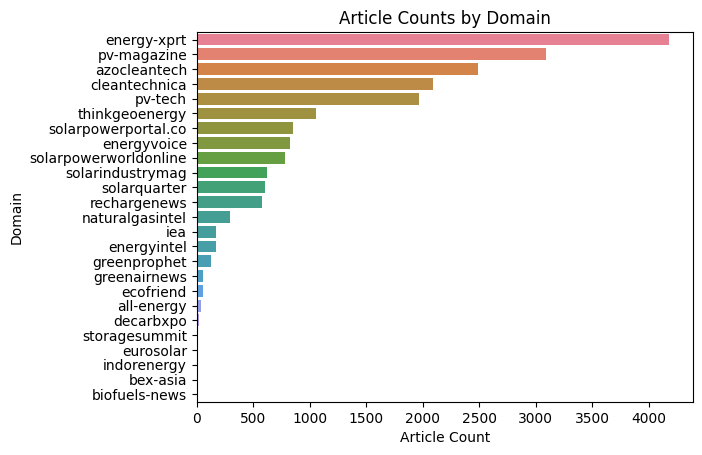

In [29]:
barplot = sns.barplot(
    x=domain_counts.values,
    y=domain_counts.index,
    hue=domain_counts.index
)

barplot.set_title('Article Counts by Domain')
barplot.set_xlabel('Article Count')
barplot.set_ylabel('Domain')

plt.show()

Our exploration of article domains reveals a skewed distribution.  Publishers like cleantechnica have a significantly higher representation (1861 articles), while others like indoenergy have minimal contributions (2 articles).  If we proceed with sampling this data, this imbalance should be taken into account. [Stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling) is the recommended  approach to ensure a representative sample across different publishers.

### Article Dates

Each article within the dataset is accompanied by a publication date. Let's delve into the temporal range of these articles and investigate any noteworthy patterns in publication trends.

In [30]:
# plot the amount of articles over time
articles_df["date"] = pd.to_datetime(articles_df["date"])
time_df = articles_df.groupby("date").size().reset_index()
time_df.columns = ["date","count"]

time_df.describe()

,date,count
count,979,979.000000
mean,2023-05-26 05:11:49.703779328,20.542390
min,2022-01-02 00:00:00,1.000000
25%,2022-09-19 12:00:00,8.000000
50%,2023-05-26 00:00:00,17.000000
75%,2024-01-30 12:00:00,23.000000
max,2024-10-24 00:00:00,1812.000000
std,NaN,76.837351


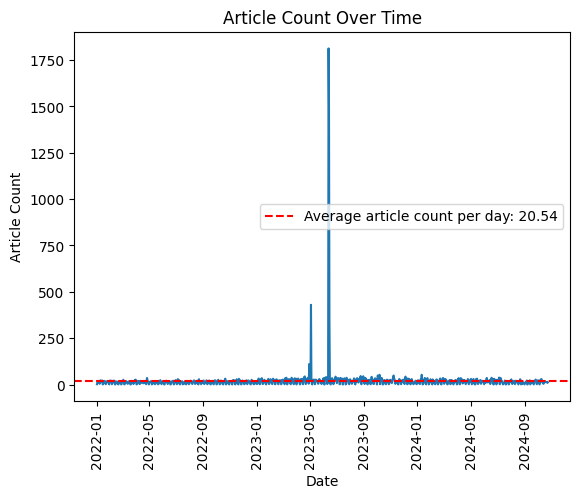

In [31]:
sns.lineplot(data=time_df, x="date", y="count")
plt.title("Article Count Over Time")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Article Count")
# add a line for the average
avg_count = time_df["count"].mean()
plt.axhline(avg_count, color='r', linestyle='--', label=f"Average article count per day: {avg_count:.2f}")
plt.legend()
plt.show()

While the daily article count appears consistent overall, a significant outlier disrupts the pattern on the 2023-12-05.  The cause of this outlier is undetermined, but it could potentially be the date the data was scraped and the default value assigned for missing dates. Since the publication date is not crucial for RAG pipeline, we can remove it.

In [32]:
articles_df = articles_df.drop(columns=["date"])

### Article Titles

As noted in our initial exploration, some articles share identical titles. Here, we'll focus on identifying and handling these duplicate titles to ensure a clean and consistent dataset for our RAG pipeline.

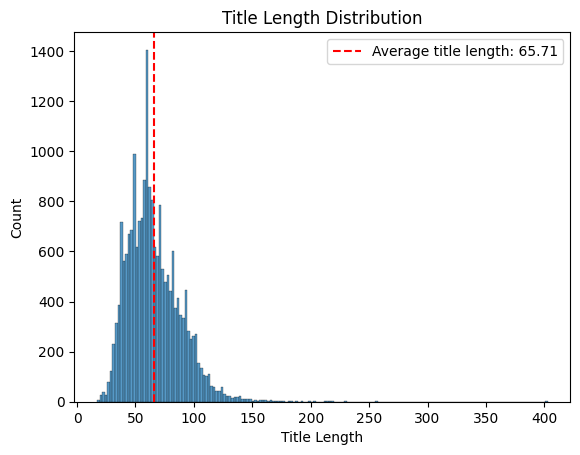

In [33]:
sns.histplot(articles_df["title"].str.len())
plt.title("Title Length Distribution")
plt.xlabel("Title Length")
plt.ylabel("Count")
avg_count = articles_df["title"].str.len().mean()
plt.axvline(avg_count, color='r', linestyle='--', label=f"Average title length: {avg_count:.2f}")
plt.legend()
plt.show()

In [34]:
articles_df["title"].duplicated().sum()

95

In [35]:
duplicate_titles = articles_df[articles_df["title"].duplicated(keep=False)].sort_values("title")
duplicate_titles.head(10)

,title,content,domain,url
105526,'Three quarters of power from wind ',['Three quarters of Dutch power will come from...,rechargenews,https://www.rechargenews.com/wind/three-quarte...
105527,'Three quarters of power from wind ',['Three quarters of Dutch power will come from...,rechargenews,https://www.rechargenews.com/wind/three-quarte...
13367,"ACWA Power: Quotes, Address, Contact",['We use cookies to enhance your experience. B...,azocleantech,https://www.azocleantech.com/suppliers.aspx?Su...
22292,"ACWA Power: Quotes, Address, Contact","[""By clicking `` Allow All '' you agree to the...",azocleantech,https://www.azocleantech.com/Suppliers.aspx?Su...
13371,"ADS-TEC Energy: Quotes, Address, Contact",['We use cookies to enhance your experience. B...,azocleantech,https://www.azocleantech.com/suppliers.aspx?Su...
22256,"ADS-TEC Energy: Quotes, Address, Contact","[""By clicking `` Allow All '' you agree to the...",azocleantech,https://www.azocleantech.com/Suppliers.aspx?Su...
22388,"ALUULA Composites Inc.: Quotes, Address, Contact","[""By clicking `` Allow All '' you agree to the...",azocleantech,https://www.azocleantech.com/Suppliers.aspx?Su...
13366,"ALUULA Composites Inc.: Quotes, Address, Contact",['We use cookies to enhance your experience. B...,azocleantech,https://www.azocleantech.com/suppliers.aspx?Su...
13375,"AMETEK STC: Quotes, Address, Contact",['We use cookies to enhance your experience. B...,azocleantech,https://www.azocleantech.com/suppliers.aspx?Su...
22396,"AMETEK STC: Quotes, Address, Contact","[""By clicking `` Allow All '' you agree to the...",azocleantech,https://www.azocleantech.com/Suppliers.aspx?Su...


In [36]:
duplicate_titles["content"].duplicated().sum()

6

Our exploration identified 24 titles that appear multiple times in the dataset. Examples include "About David J. Cross." Interestingly, while the titles are identical, the content itself appears to be unique.

Here are some additional observations for further investigation:
- A pattern was found where some articles begin with the phrase "By clicking." We'll delve into this further to determine the potential impact when analzing the article contents.
- We can observe instances of articles with seemingly similar content but differing URLs containing "sgvoice.energyvoice.com" and "energyvoice.com." Let's explore these cases to understand the potential distinction between them.

In [37]:
def wrap_text(text: str, char_per_line=100) -> str:
    # for better readability, wrap the text at the last space before the char_per_line
    if len(text) < char_per_line:
        return text
    else:
        return text[:char_per_line].rsplit(' ', 1)[0] + '\n' + wrap_text(text[len(text[:char_per_line].rsplit(' ', 1)[0])+1:], char_per_line)

In [38]:
print(duplicate_titles.iloc[0]["title"])
print(wrap_text(duplicate_titles.iloc[0]["content"]))

'Three quarters of power from wind '
['Three quarters of Dutch power will come from wind by 2031, the chief of the Netherlands Wind
Energy Association predicted, shortly after the government opened bidding for each of the Ijmujiden
Ver offshore wind sites, known respectively as Alpha 2GW and Beta 2GW.', 'Interested parties can
hand in bids between up to March 28 for the twin far offshore zones in the North Sea, in what is
the country’ s largest tender for wind at sea so far.', 'Recharge is part of DN Media Group. To
read more about DN Media Group, click here', 'Recharge is part of DN Media Group AS. From November
1st DN Media Group is responsible for controlling your data on Recharge.', 'We use your data to
ensure you have a secure and enjoyable user experience when visiting our site. You can read more
about how we handle your information in our privacy policy.', 'DN Media Group is the leading news
provider in the shipping, seafood, and energy industries, with a number of English- and


In [39]:
print(duplicate_titles.iloc[1]["title"])
print(wrap_text(duplicate_titles.iloc[1]["content"]))

'Three quarters of power from wind '
['Three quarters of Dutch power will come from wind by 2031, the chief of the Netherlands Wind
Energy Association predicted, shortly after the government opened bidding for each of the Ijmujiden
Ver offshore wind sites, known respectively as Alpha 2GW and Beta 2GW.', 'Interested parties can
hand in bids between up to March 28 for the twin far offshore zones in the North Sea, in what is
the country’ s largest tender for wind at sea so far.', 'Recharge is part of DN Media Group. To
read more about DN Media Group, click here', 'Recharge is part of DN Media Group AS. From November
1st DN Media Group is responsible for controlling your data on Recharge.', 'We use your data to
ensure you have a secure and enjoyable user experience when visiting our site. You can read more
about how we handle your information in our privacy policy.', 'DN Media Group is the leading news
provider in the shipping, seafood, and energy industries, with a number of English- and


Our analysis suggests potential redundancy within certain articles. In some cases, the second article might appear to be the first article with an additional sentence appended at the end.

Let's take a closer look at these "energyvoice" articles and how the contents start and see if we can eliminate these redundancies.

In [40]:
energyvoice_articles = articles_df[articles_df["domain"].str.contains("energyvoice")]
energyvoice_articles.content.map(lambda x: x[:50]).value_counts()

,count
content,
"['', '', 'The Megawatt Hour is the latest podcast",6
['Two years after the Amazon Pledge Fund invested,3
['A group of trade associations from across the en,3
"['Bruno Roche, Global Head of Energy Transition, A",2
['The cost of clean hydrogen will fall to that of,2
...,...
['Researchers have found an alternative way to ext,1
['Controversy has been sparked over plans to build,1
['Systems change consultancy Systemiq has released,1


In [41]:
def remove_prefix_articles(df: pd.DataFrame, prefix_len: int = 100) -> pd.DataFrame:
    """
    Takes O(n^2) time complexity
    If the first {prefix_len} characters of the article are the same, then we consider them as a prefix.
    If an article is a prefix of a longer article, then we remove it.
    If an article is a prefix of longer article, but they have different titles, then we keep them.
    """

    df["char_len"] = df["content"].map(len)
    df = df.sort_values(by='char_len', ascending=True).reset_index(drop=True)

    # Initialize a list to keep the articles that are not prefixes of others
    non_prefix_articles = []

    for i, row in df.iterrows():
        is_prefix = False
        content_i = row['content'][:prefix_len]
        title_i = row['title']

        for j in range(i + 1, len(df)):
            content_j = df.at[j, 'content'][:prefix_len]
            title_j = df.at[j, 'title']

            if content_i == content_j:
                # If the prefix matches but the titles are different, we keep it
                if title_i != title_j:
                    continue
                else:
                    is_prefix = True
                    break

        if not is_prefix:
            non_prefix_articles.append(row)

    print(f"Removed {len(df) - len(non_prefix_articles)} prefix articles")
    return pd.DataFrame(non_prefix_articles)

In [42]:
energyvoice_articles = remove_prefix_articles(energyvoice_articles)
energyvoice_articles.content.map(lambda x: x[:100]).value_counts()

Removed 11 prefix articles


,count
content,
"['', '', 'The Megawatt Hour is the latest podcast boxset brought to you by Energy Voice Out Loud in",6
['A group of trade associations from across the energy sector have written to the Chancellor urging,3
"['Two years after the Amazon Pledge Fund invested in Hippo Harvest, the company is selling its first",3
['Nicola Sturgeon will today reveal her government’ s new energy strategy on the future of the North,2
"['Bruno Roche, Global Head of Energy Transition, ABB Process Automation, Energy Industries, outlines",2
...,...
['Oil and gas giant BP ( LSE: BP) has handed out a contract for work on a key North Sea carbon captu,1
['The jacket that supported the Ninian Northern platform for decades has completed its trip from the,1
"['Over the next ten years, the Global Wind Energy Council predicts that more than 380GW of offshore",1


There still seem to be be some redundancy, but we did manage to remove 11 duplicates.

### Article Contents

Having explored various aspects of our dataset, we now turn our attention to the heart of the matter: the article content itself. This section will delve into the analysis and preprocessing techniques we'll employ to ensure the content is high-quality and effectively utilized by our RAG pipeline.

We start with a visual inspection of the article content.

In [43]:
np.random.seed(7)
random_sample_id = np.random.choice(articles_df.index)
print(wrap_text(articles_df.loc[random_sample_id, "content"]))

['Axis Energy, Juniper Green Energy, ReNew, and Acme have emerged as winners in NTPC’ s auction for
1.5 GW of wind-solar hybrid projects connected to India’ s interstate transmission system ( ISTS).
The average price was INR 3.30 ( $ 0.040) /kWh.', 'NTPC has concluded its ( Tranche-IV) tender for
ISTS-connected wind-solar hybrid capacity, with an average tariff of INR 3.30/kWh.', 'ABC Cleantech
( Axis Energy) won the biggest portion of 750 MW by quoting the lowest tariff of INR 3.27/kWh.
Juniper Green Energy secured 300 MW at INR 3.29/kWh. The rest of the capacity was allocated to
ReNew ( 300 MW) and ACME Cleantech ( 150 MW) at INR 3.32/kWh.', 'The winning developers will set up
the projects on a build-own-operate ( BOO) basis. The projects can be located anywhere in India and
must connect to the ISTS.', 'This content is protected by copyright and may not be reused. If you
want to cooperate with us and would like to reuse some of our content, please contact: editors @
pv-magazine.com.'

Our initial examination reveals that article content is currently stored as a list of strings. To gain deeper understanding and facilitate preprocessing, we'll transform these lists into a more cohesive textual format.

In [44]:
articles_df['article'] = articles_df['content'].apply(lambda x: ' '.join(eval(x)))
print(wrap_text(articles_df.loc[random_sample_id, "article"]))

Axis Energy, Juniper Green Energy, ReNew, and Acme have emerged as winners in NTPC’ s auction for
1.5 GW of wind-solar hybrid projects connected to India’ s interstate transmission system ( ISTS).
The average price was INR 3.30 ( $ 0.040) /kWh. NTPC has concluded its ( Tranche-IV) tender for
ISTS-connected wind-solar hybrid capacity, with an average tariff of INR 3.30/kWh. ABC Cleantech (
Axis Energy) won the biggest portion of 750 MW by quoting the lowest tariff of INR 3.27/kWh.
Juniper Green Energy secured 300 MW at INR 3.29/kWh. The rest of the capacity was allocated to
ReNew ( 300 MW) and ACME Cleantech ( 150 MW) at INR 3.32/kWh. The winning developers will set up
the projects on a build-own-operate ( BOO) basis. The projects can be located anywhere in India and
must connect to the ISTS. This content is protected by copyright and may not be reused. If you want
to cooperate with us and would like to reuse some of our content, please contact: editors @
pv-magazine.com. Please be mind

In [45]:
articles_df["article"].duplicated().sum()

43

In [46]:
duplicate_articles = articles_df[articles_df["article"].duplicated(keep=False)].sort_values("article")
duplicate_articles

,title,content,domain,url,article
92379,Solar Plant Monitoring ( Energy Monitoring) Ar...,"[""2023-01-10 00:00For buyers of energy meters,...",energy-xprt,https://www.energy-xprt.com/energy-monitoring/...,"2023-01-10 00:00For buyers of energy meters, t..."
89712,Solar Plant Monitoring ( Solar Energy) Articles,"[""2023-01-10 00:00For buyers of energy meters,...",energy-xprt,https://www.energy-xprt.com/solar-energy/solar...,"2023-01-10 00:00For buyers of energy meters, t..."
89587,Backup Power ( Power Distribution) News,"[""A new report shows how California's premier ...",energy-xprt,https://www.energy-xprt.com/power-distribution...,A new report shows how California's premier pu...
91830,Backup Power ( Energy Management) News,"[""A new report shows how California's premier ...",energy-xprt,https://www.energy-xprt.com/energy-management/...,A new report shows how California's premier pu...
36043,Green Prophet - Page 10 of 692 - Sustainabilit...,"['A poetic look at climate change, drought and...",greenprophet,https://www.greenprophet.com/page/10/,"A poetic look at climate change, drought and a..."
...,...,...,...,...,...
13364,"Mosaic Materials, Inc.: Quotes, Address, Contact",['We use cookies to enhance your experience. B...,azocleantech,https://www.azocleantech.com/Suppliers.aspx?Su...,We use cookies to enhance your experience. By ...
100453,Will new Portuguese administration reduce EU f...,['With ambitious decarbonization targets and a...,pv-magazine,https://www.pv-magazine.com/2024/04/09/will-ne...,With ambitious decarbonization targets and a f...
100455,How can policy help Portugal decarbonize? – pv...,['With ambitious decarbonization targets and a...,pv-magazine,https://www.pv-magazine.com/2024/04/09/will-ne...,With ambitious decarbonization targets and a f...
92336,Renewable Energy Storage ( Energy Storage) Art...,"[""YTL, as an company of electricity meter, thi...",energy-xprt,https://www.energy-xprt.com/energy-storage/ren...,"YTL, as an company of electricity meter, this ..."


Our analysis uncovers additional insights regarding content duplication. We observe cases where seemingly identical articles are reposted on the same domain but with different titles (excluding the "sgvoice.energyvoice.com" vs. "energyvoice.com" scenario previously addressed). Here, we'll strategically keep these duplicates where contents are the same but titles are different.

**Importance of Titles**

We keep these duplicate articles because titles can hold information relevant for our RAG pipeline. Consider a scenario where a user query uses an abbreviation, while the corresponding article only contains the abbreviation in the title, in the content always the full term is used. To bridge this gap, we'll prepend titles to the article content during preprocessing. This ensures that the retrieval process considers not only the content itself, but also the potentially informative titles.

**Next Step**

As previously noted, some articles exhibit standardized introductions, possibly artifacts of the data scraping process. We'll develop appropriate techniques to handle these introductions during preprocessing, ensuring they don't hinder the effectiveness of our RAG pipeline.

In [47]:
articles_df.article.map(lambda x: x[:50]).value_counts()

,count
article,
By clicking `` Allow All '' you agree to the stori,1365
We use cookies to enhance your experience. By cont,865
Sign in to get the best natural gas news and data.,295
Create a free IEA account to download our reports,173
window.dojoRequire ( [ `` mojo/signup-forms/Loader,31
...,...
My family used to say I had an obsession with Tesl,1
Poland as part of a second phase of offshore wind,1
EOIs are being accepted by KenGen for land leases,1


In [48]:
artifacts = [
    "By clicking `` Allow All '' you agree to the sto",
    "Sign in to get the best natural gas news and dat",
    "window.dojoRequire ( [ `` mojo/signup-forms/Load"
]

for artifact in artifacts:
    print(wrap_text(articles_df[articles_df.article.str.startswith(artifact)].article.iloc[0][:500]))
    print()

By clicking `` Allow All '' you agree to the storing of cookies on your device to enhance site
navigation, analyse site usage and support us in providing free open access scientific content.
More info. Waga Energy is joining forces with Steuben County ( New York, USA) on a Renewable
Natural Gas ( RNG) project at the county’ s Bath landfill. The RNG produced will be injected in the
local grid and used as a biofuel to decarbonize mobility. The Steuben County landfill will be the
first in the US to

Sign in to get the best natural gas news and data. Follow the topics you want and receive the daily
emails. Your email address * Your password * Remember me Continue Reset password Featured Content
News & Data Services Client Support Daily GPI Infrastructure | NGI All News Access Electric
transmission planners with the Eastern Interconnection, a major power grid serving two-thirds of
the United States and Canada, recently gave a favorable review in their assessment of how well
regional plans m

In [49]:
def remove_scrapping_artifacts(df: pd.DataFrame, column: str) -> pd.DataFrame:
    text_artifacts = [
        "By clicking `` Allow All '' you agree to the storing of cookies on your device to enhance site navigation, analyse site usage and support us in providing free open access scientific content. More info.",
        "Sign in to get the best natural gas news and data. Follow the topics you want and receive the daily emails. Your email address * Your password * Remember me Continue Reset password Featured Content News & Data Services Client Support"
    ]

    regex_artifacts = [
        r"window.dojoRequire \( \[ .*\}\) \}\) "
    ]

    for pattern in text_artifacts:
        articles_df[column] = articles_df[column].str.replace(pattern, '', regex=False)

    for pattern in regex_artifacts:
        articles_df[column] = articles_df[column].str.replace(pattern, '', regex=True)

    return df

In [50]:
articles_df = remove_scrapping_artifacts(articles_df, "article")
articles_df.article.map(lambda x: x[:50]).value_counts()

,count
article,
We use cookies to enhance your experience. By cont,865
Create a free IEA account to download our reports,173
Welcome to Edinburgh Instruments’ monthly blog cel,26
Hydrogen Technology Expo & Carbon Capture Technolo,22
Over the last year Kipp & Zonen has received a lot,21
...,...
"If an electric car charges while driving, the siz",1
A Brazilian study sets the stage for increased ef,1
The Windhager PuroWIN is the first wood chip boile,1


Our efforts have successfully eliminated a substantial portion of the scrapping artifacts within the articles. However, some traces  still persist, likely remnants of past website navigation structures. While removing these remaining artifacts could offer further refinement, it also presents a significant challenge. Therefore, we'll acknowledge this for now and move onto further preprocessing such as filtering out articles that are not written in English.

In [51]:
articles_df["lang"] = articles_df["article"].map(detect)
articles_df["lang"].value_counts()

,count
lang,
en,20107
de,3
ru,1


We will first inspect the language-specific assessment of our texts.

In [ ]:
articles_df[articles_df["lang"] != "en"]

In [ ]:
print(wrap_text(articles_df[articles_df["lang"] != "en"].iloc[1]["article"][1000:]))

In [ ]:
articles_df = articles_df[articles_df["lang"] == "en"]

#### Patent Datset

### Patent Domains/Topics


In [ ]:
patents_df_unique_en.describe()

In [ ]:
patents_df_unique_en.info()

In [ ]:
!pip install nltk

In [ ]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

####preprocess patent data

In [ ]:
# Assuming patents_df_unique is already loaded with the data you pasted
patents_df = patents_df_unique_en.copy()

# Combine title + abstract
patents_df["text"] = patents_df["title"].fillna("") + ". " + patents_df["abstract"].fillna("")

# Basic preprocessing
stop_words = set(stopwords.words("english"))
def preprocess_text(text, apply_stemming=False):
    """
    Preprocess a given text by:
      - Converting to lowercase
      - Tokenizing
      - Removing punctuation and stop words
      - Applying lemmatization (and optionally stemming)
    """
    if not isinstance(text, str):
        return []

    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    if apply_stemming:
        tokens = [stemmer.stem(token) for token in tokens]

    # Join the tokens back into a single string
    return " ".join(tokens)


patents_df["cleaned_text"] = patents_df["text"].apply(preprocess_text)

####Vectorize with TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(patents_df["cleaned_text"])

####Extract Topics with NMF

In [ ]:
n_topics = 10  # You can change this depending on how many topics you want
nmf_model = NMF(n_components=n_topics, random_state=42)
nmf_features = nmf_model.fit_transform(tfidf)

# Show top keywords per topic
for i, topic in enumerate(nmf_model.components_):
    top_keywords = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
    print(f"Topic {i}: {', '.join(top_keywords)}")


In [ ]:
patents_df["topic"] = nmf_features.argmax(axis=1)

# Show topic distribution
topic_distribution = patents_df["topic"].value_counts().sort_index()
print("\nTopic distribution:")
print(topic_distribution)


In [ ]:
colors = plt.cm.viridis(np.linspace(0, 1, len(topic_distribution)))  # Use viridis colormap
plt.bar(topic_distribution.index, topic_distribution.values, color=colors)
plt.xlabel("Topic Number")
plt.ylabel("Number of Documents")
plt.title("Topic Distribution")
plt.show()

####Patent Dates

In [ ]:
patents_df["publication_date"] = pd.to_datetime(patents_df["publication_date"].astype(str), errors='coerce') # Use errors='coerce' to handle invalid dates

# Similar to articles_df date handling:
patents_time_df = patents_df.groupby("publication_date").size().reset_index()
patents_time_df.columns = ["publication_date", "count"]

patents_time_df.describe()

In [ ]:
sns.lineplot(data=patents_time_df, x="publication_date", y="count")
plt.title("Patent Article Count Over Time")
plt.xlabel("Publication Date")
plt.xticks(rotation=90)
plt.ylabel("Patent Article Count")
# add a line for the average
avg_count = patents_time_df["count"].mean()
plt.axhline(avg_count, color='r', linestyle='--', label=f"Average article count per day: {avg_count:.2f}")
plt.legend()
plt.show()

####Patent CPC code and inventor

In [ ]:
from collections import defaultdict

inventor_counts = defaultdict(int)

for inventor_list in patents_df['inventor']:
    if inventor_list:
        for inventor in inventor_list:
            inventor_counts[inventor] += 1

# Convert the dictionary to a DataFrame
patents_new_df = pd.DataFrame(inventor_counts.items(), columns=['inventor', 'count'])

patents_new_df.describe()

In [ ]:
patents_cpc_df = patents_df.groupby("cpc_code").size().reset_index()
patents_cpc_df.columns = ["cpc_code", "count"]

patents_cpc_df.describe()

### Patent Titles

In [ ]:
sns.histplot(patents_df["title"].str.len())
plt.title("Title Length Distribution")
plt.xlabel("Title Length")
plt.ylabel("Count")
avg_count = patents_df["title"].str.len().mean()
plt.axvline(avg_count, color='r', linestyle='--', label=f"Average title length: {avg_count:.2f}")
plt.legend()
plt.show()

In [ ]:
patents_df["title"].duplicated().sum()

In [ ]:
duplicate_titles = patents_df[patents_df["title"].duplicated(keep=False)].sort_values("title")
duplicate_titles.head(10)

In [ ]:
duplicate_titles["abstract"].duplicated().sum()

for better readability wrap text

In [ ]:
def wrap_text(text: str, char_per_line=100) -> str:
    # for better readability, wrap the text at the last space before the char_per_line
    if len(text) < char_per_line:
        return text
    else:
        return text[:char_per_line].rsplit(' ', 1)[0] + '\n' + wrap_text(text[len(text[:char_per_line].rsplit(' ', 1)[0])+1:], char_per_line)

In [ ]:
print(duplicate_titles.iloc[0]["title"])
print(wrap_text(duplicate_titles.iloc[0]["abstract"]))

In [ ]:
print(duplicate_titles.iloc[1]["title"])
print(wrap_text(duplicate_titles.iloc[1]["abstract"]))

### Patents Abstract

In [ ]:
np.random.seed(7)
random_sample_id = np.random.choice(patents_df.index)
print(wrap_text(patents_df.loc[random_sample_id, "abstract"]))

In [ ]:
patents_df_unique

In [ ]:
# Count detected languages in title
title_lang_counts = patents_df_unique["title_lang"].value_counts()
print("Title Language Counts:")
print(title_lang_counts)

# Count detected languages in abstract
abstract_lang_counts = patents_df_unique["abstract_lang"].value_counts()
print("\nAbstract Language Counts:")
print(abstract_lang_counts)


Our exploration revealed a small number of articles containing non-English content (some in German and 1 with a Russian section).  Since most LLMs and embedding models are primarily trained on English text, removing these articles ensures compatibility with our chosen models for this notebook. For simplicity, we'll only focus on supporting English queries and responses within this RAG pipeline.

#### Challenges of Multilingual RAG Pipelines

Introducing multilingual capabilities into a RAG pipeline presents an additional layer of complexity. Here's a breakdown of some key challenges:

- **Multilingual Model Support:** Both the LLM and embedding models need to be proficient in all target languages (e.g., English and German). The LLM must be able to comprehend and generate text in these languages, while the embedding models should effectively map similar concepts across languages into the same semantic space.
- **Prompt Engineering for Multilingual Responses:** When a user submits a question in German, for instance, we'd ideally retrieve relevant articles, potentially also in English which can distract the LLM, and utilize prompt engineering to ensure the LLM generates a response in German.

#### Characters, Tokens and Words

Let us further analyze the contents of the articles. However, before we do so let us define the meaning of characters, tokens and words:
- **Characters:** The smallest unit of text, including letters, numbers, punctuation, and whitespace.
- **Tokens:** Most NLP models operate on tokens, which are sequences of characters that represent a semantic unit. These units can be words, subwords, or characters. Tokenization is the process of converting text into tokens. To see the tokenization process in action for the OpenAI GPT-4 model, check out the [OpenAI GPT-4 Tokenizer](https://platform.openai.com/tokenizer).
- **Words:** Just as in everyday's language, words are the building blocks of text. They are composed of one or more characters and are separated by whitespace.

### Media Dataset

In [ ]:
sns.histplot(articles_df["article"].map(len), kde=True)

plt.title("Amount of characters in articles")
plt.xlabel("Amount of characters")
plt.ylabel("Number of articles")
median_char_len = articles_df["article"].map(len).median()
mean_char_len = articles_df["article"].map(len).mean()
plt.axvline(median_char_len, color='r', linestyle='--', label=f"Median character amount: {median_char_len:.2f}")
plt.axvline(mean_char_len, color='g', linestyle='--', label=f"Mean character amount: {mean_char_len:.2f}")
plt.legend()
plt.show()

In [ ]:
sns.histplot(articles_df["article"].map(lambda x: len(x.split())), kde=True)

plt.title("Amount of words in articles")
plt.xlabel("Amount of words")
plt.ylabel("Number of articles")
median_word_len = articles_df["article"].map(lambda x: len(x.split())).median()
mean_word_len = articles_df["article"].map(lambda x: len(x.split())).mean()
plt.axvline(median_word_len, color='r', linestyle='--', label=f"Median word amount: {median_word_len:.2f}")
plt.axvline(mean_word_len, color='g', linestyle='--', label=f"Mean word amount: {mean_word_len:.2f}")
plt.legend()
plt.show()

In [ ]:
nlp = English()
tokenizer = nlp.tokenizer

sns.histplot(articles_df["article"].map(lambda x: len(tokenizer(x))), kde=True)

plt.title("Amount of tokens in articles")
plt.xlabel("Amount of tokens")
plt.ylabel("Number of articles")
median_token_len = articles_df["article"].map(lambda x: len(tokenizer(x))).median()
mean_token_len = articles_df["article"].map(lambda x: len(tokenizer(x))).mean()
plt.axvline(median_token_len, color='r', linestyle='--', label=f"Median token amount: {median_token_len:.2f}")
plt.axvline(mean_token_len, color='g', linestyle='--', label=f"Mean token amount: {mean_token_len:.2f}")
plt.legend()
plt.show()

In [ ]:
all_tokens = [token.text for article in articles_df["article"] for token in tokenizer(article)]
# remove non-alphabetic tokens such as punctuation
alpha_tokens = [token for token in all_tokens if token.isalpha()]
alpha_tokens = [token.lower() for token in alpha_tokens]
alpha_token_counts = Counter(alpha_tokens)

sns.barplot(
    x=[count for token, count in alpha_token_counts.most_common(20)],
    y=[token for token, count in alpha_token_counts.most_common(20)],
    hue=[token for token, count in alpha_token_counts.most_common(20)]
)

plt.title("Most common alphabetic tokens")
plt.xlabel("Count")
plt.ylabel("Token")
plt.show()

The initial approach returns common words which do not reflect the subject-specific nature of our document collection. We will remove them to understand the content of the texts better.

In [ ]:
# remove stopwords such as 'the', 'a', 'and'
non_stop_tokens = [token for token in alpha_tokens if not nlp.vocab[token].is_stop]
non_stop_token_counts = Counter(non_stop_tokens)

sns.barplot(
    x=[count for token, count in non_stop_token_counts.most_common(20)],
    y=[token for token, count in non_stop_token_counts.most_common(20)],
    hue=[token for token, count in non_stop_token_counts.most_common(20)]
)

plt.title("Most common non-stopword tokens")
plt.xlabel("Count")
plt.ylabel("Token")
plt.show()

As one would expect in a dataset of cleantech news articles most of the tokens that are not punctation or stopwords revolve around the subjects of energy, climate, and technology. This is a good sign that the dataset is relevant to the topic at hand. The "s" token comes up frequently, which is likely due to the possessive form of words. With an average of around 700 words per article, we can expect a good amount of information to be present in each article and an average reading time of around 3-4 minutes.

#### Flesch Reading Ease Score

The Flesch Reading Ease Score (FRES, a.k.a Flesch-Kincaid Reading Ease Score) is a heuristic used to evaluate how easy it is to understand a text based on the length of sentences and the number of syllables per word. Scores can range from -100 (very difficult to read) to 100 (very easy to read). Scores below 50 are indicative of difficult texts for College level. This metric can be useful for assessing the readability of our articles and ensuring they are accessible to a broad audience.

In [ ]:
articles_df["readability"] = articles_df["article"].apply(flesch_reading_ease)

sns.histplot(articles_df["readability"], kde=True)

plt.title("Flesch Reading Ease of articles")
plt.xlabel("Flesch Reading Ease")
plt.ylabel("Number of articles")
mean_readability = articles_df["readability"].mean()
plt.axvline(mean_readability, color='g', linestyle='--', label=f"Mean readability: {mean_readability:.2f}")
plt.legend()
plt.show()

We analyze now the diversity of language complexity used by different publishing domains.

In [ ]:
domains = articles_df["domain"].unique()

# Setup the subplots based on the number of domains
plots_per_row = 3
num_rows = (len(domains) + 2) // plots_per_row
plot_height = 6
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plot_height * plots_per_row, plot_height * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Plot for each domain
for i, domain in enumerate(domains):
    domain_articles = articles_df[articles_df["domain"] == domain]
    sns.histplot(domain_articles["readability"], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Readability of {domain}')
    axes[i].set_xlabel('Flesch Reading Ease Score')
    axes[i].set_ylabel("Number of articles")
    mean_readability = domain_articles["readability"].mean()
    axes[i].axvline(mean_readability, color='g', linestyle='--', label=f"Mean readability: {mean_readability:.2f}")

# remove the empty plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

To gauge the readability of our articles, we calculated the Flesch Reading Ease Score. The average score of around 45 indicates a "fairly easy" reading level, which is positive news. This suggests the content is likely accessible to a broad audience and, consequently, understandable by our RAG pipeline as well.

Our analysis revealed a consistent average Flesch Reading Ease Score across most of the identified domains, with minor variations. This indicates a relatively consistent level of readability across different publishers within the dataset.

Finally we will save the cleaned dataset to a new file in the `data/silver` folder.

In [85]:
silver_folder = data_folder / "silver"
if not silver_folder.exists():
    silver_folder.mkdir()

articles_df.to_csv(silver_folder / "articles.csv", index=False)

### Patent Dataset

In [ ]:
sns.histplot(patents_df_unique_en["abstract"].map(len), kde=True)

plt.title("Amount of characters in abstracts")
plt.xlabel("Amount of characters")
plt.ylabel("Number of Abstracts")
median_char_len = patents_df_unique_en["abstract"].map(len).median()
mean_char_len = patents_df_unique_en["abstract"].map(len).mean()
plt.axvline(median_char_len, color='r', linestyle='--', label=f"Median character amount: {median_char_len:.2f}")
plt.axvline(mean_char_len, color='g', linestyle='--', label=f"Mean character amount: {mean_char_len:.2f}")
plt.legend()
plt.show()

In [ ]:
patents_df_unique_en[patents_df_unique_en["abstract"].map(len) <50]

In [ ]:
sns.histplot(patents_df_unique_en["abstract"].map(lambda x: len(x.split())), kde=True)

plt.title("Amount of words in abstracts")
plt.xlabel("Amount of words")
plt.ylabel("Number of abstracts")
median_word_len = patents_df_unique_en["abstract"].map(lambda x: len(x.split())).median()
mean_word_len = patents_df_unique_en["abstract"].map(lambda x: len(x.split())).mean()
plt.axvline(median_word_len, color='r', linestyle='--', label=f"Median word amount: {median_word_len:.2f}")
plt.axvline(mean_word_len, color='g', linestyle='--', label=f"Mean word amount: {mean_word_len:.2f}")
plt.legend()
plt.show()

In [ ]:
nlp = English()
tokenizer = nlp.tokenizer

sns.histplot(patents_df_unique_en["abstract"].map(lambda x: len(tokenizer(x))), kde=True)

plt.title("Amount of tokens in abstracts")
plt.xlabel("Amount of tokens")
plt.ylabel("Number of abstracts")
median_token_len = patents_df_unique_en["abstract"].map(lambda x: len(tokenizer(x))).median()
mean_token_len = patents_df_unique_en["abstract"].map(lambda x: len(tokenizer(x))).mean()
plt.axvline(median_token_len, color='r', linestyle='--', label=f"Median token amount: {median_token_len:.2f}")
plt.axvline(mean_token_len, color='g', linestyle='--', label=f"Mean token amount: {mean_token_len:.2f}")
plt.legend()
plt.show()

In [ ]:
all_tokens = [token.text for article in patents_df_unique_en["abstract"] for token in tokenizer(article)]
# remove non-alphabetic tokens such as punctuation
alpha_tokens = [token for token in all_tokens if token.isalpha()]
alpha_tokens = [token.lower() for token in alpha_tokens]
alpha_token_counts = Counter(alpha_tokens)

sns.barplot(
    x=[count for token, count in alpha_token_counts.most_common(20)],
    y=[token for token, count in alpha_token_counts.most_common(20)],
    hue=[token for token, count in alpha_token_counts.most_common(20)]
)

plt.title("Most common alphabetic tokens")
plt.xlabel("Count")
plt.ylabel("Token")
plt.show()

In [ ]:
# remove stopwords such as 'the', 'a', 'and'
non_stop_tokens = [token for token in alpha_tokens if not nlp.vocab[token].is_stop]
non_stop_token_counts = Counter(non_stop_tokens)

sns.barplot(
    x=[count for token, count in non_stop_token_counts.most_common(20)],
    y=[token for token, count in non_stop_token_counts.most_common(20)],
    hue=[token for token, count in non_stop_token_counts.most_common(20)]
)

plt.title("Most common non-stopword tokens")
plt.xlabel("Count")
plt.ylabel("Token")
plt.show()

#### Flesch Reading Ease Score



In [ ]:
patents_df_unique_en["readability"] = patents_df_unique_en["abstract"].apply(flesch_reading_ease)

sns.histplot(patents_df_unique_en["readability"], kde=True)

plt.title("Flesch Reading Ease of abstracts")
plt.xlabel("Flesch Reading Ease")
plt.ylabel("Number of articles")
mean_readability = patents_df_unique_en["readability"].mean()
plt.axvline(mean_readability, color='g', linestyle='--', label=f"Mean readability: {mean_readability:.2f}")
plt.legend()
plt.show()

# todo for patent dataset

In [ ]:
# domains = articles_df["domain"].unique()

# # Setup the subplots based on the number of domains
# plots_per_row = 3
# num_rows = (len(domains) + 2) // plots_per_row
# plot_height = 6
# fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plot_height * plots_per_row, plot_height * num_rows))
# axes = axes.flatten()  # Flatten the axes array for easier iteration

# # Plot for each domain
# for i, domain in enumerate(domains):
#     domain_articles = articles_df[articles_df["domain"] == domain]
#     sns.histplot(domain_articles["readability"], kde=True, ax=axes[i], bins=30)
#     axes[i].set_title(f'Readability of {domain}')
#     axes[i].set_xlabel('Flesch Reading Ease Score')
#     axes[i].set_ylabel("Number of articles")
#     mean_readability = domain_articles["readability"].mean()
#     axes[i].axvline(mean_readability, color='g', linestyle='--', label=f"Mean readability: {mean_readability:.2f}")

# # remove the empty plots
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()

In [ ]:
silver_folder = data_folder / "silver"
if not silver_folder.exists():
    silver_folder.mkdir()

patents_df_unique_en.to_csv(silver_folder / "abstracts.csv", index=False)

### Evaluation Data

Next we will analyze the provided evaluation data and ensure that they match the content of the articles.

In [ ]:
human_eval_df.info()

In [ ]:
human_eval_df.rename(columns={"relevant_text":"relevant_section","article_url": "url"}, inplace=True)
human_eval_df.drop(columns=["question_id"], inplace=True)
human_eval_df.head()

In [ ]:
sns.histplot(human_eval_df["question"].map(len), kde=True)
plt.title("Question Character Length Distribution")
plt.xlabel("Character Length")
plt.ylabel("Count")
mean_char_len = human_eval_df["question"].map(len).mean()
plt.axvline(mean_char_len, color='r', linestyle='--', label=f"Mean character amount: {mean_char_len:.2f}")
plt.legend()
plt.show()

In [ ]:
missing_articles = human_eval_df.copy()
missing_articles = missing_articles[~human_eval_df["url"].isin(articles_df["url"])]
missing_articles

Our exploration has identified instances where articles linked to specific questions appear to be missing from the dataset.  To determine the root cause, let's investigate whether these articles are genuinely absent or if inconsistencies in URL formatting are creating the illusion of missing data.  Normalizing the URLs across the dataset will help us differentiate between these two scenarios.

In [ ]:
def normalize_url(url: str) -> str:
    url = url.replace("https://", "")
    url = url.replace("http://", "")
    url = url.replace("www.", "")
    url = url.rstrip("/")
    return url

articles_df["url"] = articles_df["url"].map(normalize_url)
human_eval_df["url"] = human_eval_df["url"].map(normalize_url)

missing_articles = human_eval_df.copy()
missing_articles = missing_articles[~human_eval_df["url"].isin(articles_df["url"])]
missing_articles

We also know from previous analysis that some duplicate articles from the "energyvoice" domain so we will also normalize these URLs.

In [ ]:
missing_articles["url"] = missing_articles["url"].map(lambda x: x.replace("sgvoice.net", "sgvoice.energyvoice.com"))

In [ ]:
missing_articles[~missing_articles["url"].isin(articles_df["url"])]

In [ ]:
human_eval_df.loc[missing_articles.index, "url"] = missing_articles["url"]
human_eval_df[human_eval_df["url"].isin(articles_df["url"])]

In the end we are able to find all the articles that are linked to the evaluation data and have therefore successfully completed our exploratory data analysis and preprocessing.

#### Generated Evaluation QA pairs

In [ ]:
human_eval_df_media.info()

In [ ]:
human_eval_df_patent.info()

In [ ]:
human_eval_df_media_cleaned.info()

In [ ]:
human_eval_df_patent_cleaned.info()

####all  media QA Pairs

In [ ]:
human_eval_df_media.rename(columns={"relevant_text":"relevant_section","article_url": "url","Unnamed: 0": "id"}, inplace=True)
human_eval_df_media.head()

In [ ]:
sns.histplot(human_eval_df_media["question"].map(len), kde=True)
plt.title("Question Character Length Distribution")
plt.xlabel("Character Length")
plt.ylabel("Count")
mean_char_len = human_eval_df_media["question"].map(len).mean()
plt.axvline(mean_char_len, color='r', linestyle='--', label=f"Mean character amount: {mean_char_len:.2f}")
plt.legend()
plt.show()

In [ ]:
missing_articles = human_eval_df_media.copy()
missing_articles = missing_articles[~human_eval_df_media["url"].isin(articles_df["url"])]
missing_articles

In [ ]:
articles_df["url"] = articles_df["url"].map(normalize_url)
human_eval_df_media["url"] = human_eval_df_media["url"].map(normalize_url)

missing_articles = human_eval_df_media.copy()
missing_articles = missing_articles[~human_eval_df_media["url"].isin(articles_df["url"])]
missing_articles

In [ ]:
missing_articles["url"] = missing_articles["url"].map(lambda x: x.replace("sgvoice.net", "sgvoice.energyvoice.com"))

In [ ]:
missing_articles[~missing_articles["url"].isin(articles_df["url"])]

In [ ]:
human_eval_df_media.loc[missing_articles.index, "url"] = missing_articles["url"]
human_eval_df_media[human_eval_df_media["url"].isin(articles_df["url"])]

#### evaluated media QA Pairs

In [ ]:
human_eval_df_media_cleaned.rename(columns={"context":"relevant_section","source_doc": "url","Unnamed: 0": "id"}, inplace=True)
human_eval_df_media_cleaned.head()

In [ ]:
sns.histplot(human_eval_df_media_cleaned["question"].map(len), kde=True)
plt.title("Question Character Length Distribution")
plt.xlabel("Character Length")
plt.ylabel("Count")
mean_char_len = human_eval_df_media_cleaned["question"].map(len).mean()
plt.axvline(mean_char_len, color='r', linestyle='--', label=f"Mean character amount: {mean_char_len:.2f}")
plt.legend()
plt.show()

In [ ]:
missing_articles = human_eval_df_media_cleaned.copy()
missing_articles = missing_articles[~human_eval_df_media_cleaned["url"].isin(articles_df["url"])]
missing_articles

In [ ]:
articles_df["url"] = articles_df["url"].map(normalize_url)
human_eval_df_media_cleaned["url"] = human_eval_df_media_cleaned["url"].map(normalize_url)

missing_articles = human_eval_df_media_cleaned.copy()
missing_articles = missing_articles[~human_eval_df_media_cleaned["url"].isin(articles_df["url"])]
missing_articles

In [118]:
missing_articles["url"] = missing_articles["url"].map(lambda x: x.replace("sgvoice.net", "sgvoice.energyvoice.com"))

In [ ]:
missing_articles[~missing_articles["url"].isin(articles_df["url"])]

In [ ]:
human_eval_df_media_cleaned.loc[missing_articles.index, "url"] = missing_articles["url"]
human_eval_df_media_cleaned[human_eval_df_media_cleaned["url"].isin(articles_df["url"])]

In [ ]:
human_eval_df_patent.rename(columns={"relevant_text":"relevant_section"}, inplace=True)
human_eval_df_patent.head()


In [ ]:
sns.histplot(human_eval_df_patent["question"].map(len), kde=True)
plt.title("Question Character Length Distribution")
plt.xlabel("Character Length")
plt.ylabel("Count")
mean_char_len = human_eval_df_patent["question"].map(len).mean()
plt.axvline(mean_char_len, color='r', linestyle='--', label=f"Mean character amount: {mean_char_len:.2f}")
plt.legend()
plt.show()

In [ ]:
human_eval_df_patent_cleaned.rename(columns={"context":"relevant_section"}, inplace=True)
human_eval_df_patent_cleaned.head()


In [ ]:
sns.histplot(human_eval_df_patent_cleaned["question"].map(len), kde=True)
plt.title("Question Character Length Distribution")
plt.xlabel("Character Length")
plt.ylabel("Count")
mean_char_len = human_eval_df_patent_cleaned["question"].map(len).mean()
plt.axvline(mean_char_len, color='r', linestyle='--', label=f"Mean character amount: {mean_char_len:.2f}")
plt.legend()
plt.show()

## Subsampling

For faster processing and to reduce the cost of running the notebook we will subsample the dataset to 1000 articles. This will allow us to run the notebook in a reasonable amount of time and still provide meaningful results. Because the distribution of articles across publishers is skewed we will use stratified sampling to ensure that we have a representative sample. We also need to keep in mind that the evaluation data are linked to specific articles so we need to make sure that these are included in the subsample.

In [ ]:
eval_articles_df = articles_df[articles_df["url"].isin(human_eval_df["url"])]
eval_articles_df.head()

In [ ]:
print(eval_articles_df["url"].unique().shape)
print(human_eval_df["url"].unique().shape)

In [127]:
def do_stratification(
        df: pd.DataFrame,
        column: str,
        sample_size: int,
        seed: int = 42
) -> pd.DataFrame:
    res_df = df.copy()
    indx = df.groupby(column, group_keys=False)[column].apply(lambda x: x.sample(n=int(sample_size/len(df) * len(x)), random_state=seed)).index.to_list()
    return res_df.loc[indx]

In [128]:
sample_df = do_stratification(articles_df, "domain", 1000, 69)
# if the articles are already in the subsample from the evaluation set, then we remove them, so we just want unique urls
sample_df = sample_df[~sample_df["url"].isin(eval_articles_df["url"])]
sample_df = pd.concat([sample_df, eval_articles_df])
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 17313 to 63679
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        1004 non-null   object 
 1   content      1004 non-null   object 
 2   domain       1004 non-null   object 
 3   url          1004 non-null   object 
 4   article      1004 non-null   object 
 5   lang         1004 non-null   object 
 6   readability  1004 non-null   float64
dtypes: float64(1), object(6)
memory usage: 62.8+ KB


In [129]:
domain_counts = sample_df['domain'].value_counts()
print(domain_counts)

domain
energy-xprt              207
pv-magazine              155
azocleantech             128
cleantechnica            110
pv-tech                   97
thinkgeoenergy            53
energyvoice               43
solarpowerportal.co       42
solarpowerworldonline     39
solarindustrymag          31
solarquarter              30
rechargenews              28
naturalgasintel           14
iea                        8
energyintel                8
greenprophet               6
greenairnews               2
ecofriend                  2
all-energy                 1
Name: count, dtype: int64


To make sure that the distributional characteristics has not been changed by subsampling we visualize and compare both data sets in relative terms.

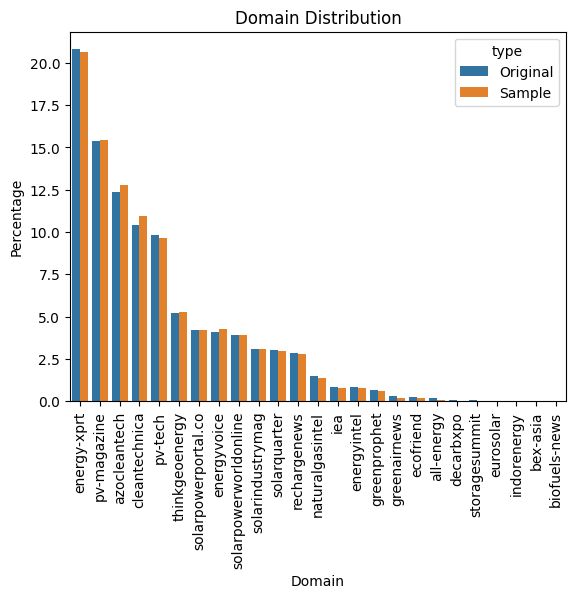

In [130]:
original_domain_counts = articles_df["domain"].value_counts().to_frame()
original_domain_counts = original_domain_counts / original_domain_counts.sum() * 100
domain_counts_df = original_domain_counts.copy()
domain_counts_df["type"] = "Original"


sample_domain_counts = sample_df["domain"].value_counts().to_frame()
sample_domain_counts = sample_domain_counts / sample_domain_counts.sum() * 100
sample_domain_counts["type"] = "Sample"

domain_counts_df = pd.concat([domain_counts_df, sample_domain_counts])
sns.barplot(
    x=domain_counts_df.index,
    y=domain_counts_df["count"],
    hue=domain_counts_df["type"]
)
plt.title("Domain Distribution")
plt.xlabel("Domain")
plt.ylabel("Percentage")
plt.xticks(rotation=90)
plt.show()

Now all is prepared to start developing our RAG!

### For generated Media QA pairs



In [131]:
eval_articles_df_media = articles_df[articles_df["url"].isin(human_eval_df_media["url"])]
eval_articles_df_media.head()

,title,content,domain,url,article,lang,readability
63200,NREL Project Investigates Wind Condition Impac...,['High wind loads increase structural design c...,solarindustrymag,solarindustrymag.com/nrel-project-investigates...,High wind loads increase structural design cos...,en,30.09
42863,Patrick Harvie: Ukraine invasion doesn't justi...,['Scottish Green party co-leader Patrick Harvi...,energyvoice,energyvoice.com/oilandgas/europe/395102/north-...,Scottish Green party co-leader Patrick Harvie ...,en,52.12
98356,South Korea tests photovoltaics on railroad no...,['Land-scarce South Korea is currently hosting...,pv-magazine,pv-magazine.com/2022/04/21/south-korea-tests-p...,Land-scarce South Korea is currently hosting a...,en,52.09
98368,Quebec publishes draft documents for 1.3 GW te...,['The Canadian provincial government’ s Green ...,pv-magazine,pv-magazine.com/2022/04/27/quebec-publishes-dr...,The Canadian provincial government’ s Green Ec...,en,40.69
63288,New SEIA Nonprofit Serves to Advance Solar Ind...,['The Solar Energy Industries Association ( SE...,solarindustrymag,solarindustrymag.com/new-seia-nonprofit-serves...,The Solar Energy Industries Association ( SEIA...,en,38.05


In [132]:
print(eval_articles_df_media["url"].unique().shape)
print(human_eval_df_media["url"].unique().shape)

(49,)
(49,)


In [133]:
sample_df_media = do_stratification(articles_df, "domain", 1000, 69)
# if the articles are already in the subsample from the evaluation set, then we remove them, so we just want unique urls
sample_df_media = sample_df_media[~sample_df_media["url"].isin(eval_articles_df_media["url"])]
sample_df_media = pd.concat([sample_df_media, eval_articles_df_media])
sample_df_media.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1033 entries, 17313 to 23380
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        1033 non-null   object 
 1   content      1033 non-null   object 
 2   domain       1033 non-null   object 
 3   url          1033 non-null   object 
 4   article      1033 non-null   object 
 5   lang         1033 non-null   object 
 6   readability  1033 non-null   float64
dtypes: float64(1), object(6)
memory usage: 64.6+ KB


In [134]:
domain_counts = sample_df_media['domain'].value_counts()
print(domain_counts)

domain
energy-xprt              207
pv-magazine              161
azocleantech             130
cleantechnica            118
pv-tech                   97
thinkgeoenergy            52
energyvoice               51
solarpowerportal.co       42
solarpowerworldonline     39
solarindustrymag          37
solarquarter              30
rechargenews              28
naturalgasintel           14
iea                        8
energyintel                8
greenprophet               6
greenairnews               2
ecofriend                  2
all-energy                 1
Name: count, dtype: int64


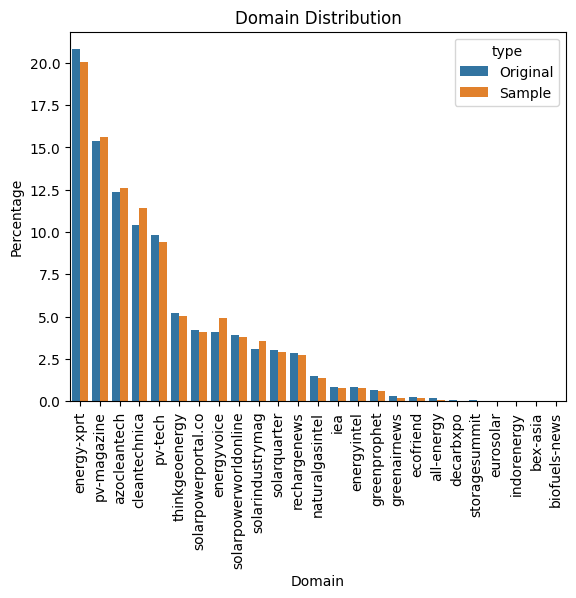

In [135]:
original_domain_counts = articles_df["domain"].value_counts().to_frame()
original_domain_counts = original_domain_counts / original_domain_counts.sum() * 100
domain_counts_df = original_domain_counts.copy()
domain_counts_df["type"] = "Original"


sample_domain_counts = sample_df_media["domain"].value_counts().to_frame()
sample_domain_counts = sample_domain_counts / sample_domain_counts.sum() * 100
sample_domain_counts["type"] = "Sample"

domain_counts_df = pd.concat([domain_counts_df, sample_domain_counts])
sns.barplot(
    x=domain_counts_df.index,
    y=domain_counts_df["count"],
    hue=domain_counts_df["type"]
)
plt.title("Domain Distribution")
plt.xlabel("Domain")
plt.ylabel("Percentage")
plt.xticks(rotation=90)
plt.show()

### For Evaluated Media QA pairs

In [136]:
eval_articles_df_media_cleaned = articles_df[articles_df["url"].isin(human_eval_df_media_cleaned["url"])]
eval_articles_df_media_cleaned.head()

,title,content,domain,url,article,lang,readability
42863,Patrick Harvie: Ukraine invasion doesn't justi...,['Scottish Green party co-leader Patrick Harvi...,energyvoice,energyvoice.com/oilandgas/europe/395102/north-...,Scottish Green party co-leader Patrick Harvie ...,en,52.12
63288,New SEIA Nonprofit Serves to Advance Solar Ind...,['The Solar Energy Industries Association ( SE...,solarindustrymag,solarindustrymag.com/new-seia-nonprofit-serves...,The Solar Energy Industries Association ( SEIA...,en,38.05
63294,Hanwha Invests $ 320 Million in Solar Cell Man...,"['Hanwha Solutions, a Korean company that owns...",solarindustrymag,solarindustrymag.com/hanwha-invests-320-millio...,"Hanwha Solutions, a Korean company that owns c...",en,38.01
21281,Latest Developments in Electric Vehicle Batter...,"[""By clicking `` Allow All '' you agree to the...",azocleantech,azocleantech.com/article.aspx?ArticleID=1597,Lithium-ion batteries are used in nearly ever...,en,43.43
63332,Nelnet Acquires GRNE Solar EPC Company and Assets,['Nelnet has acquired a controlling investment...,solarindustrymag,solarindustrymag.com/nelnet-acquires-grne-sola...,Nelnet has acquired a controlling investment i...,en,36.79


In [137]:
print(eval_articles_df_media_cleaned["url"].unique().shape)
print(human_eval_df_media_cleaned["url"].unique().shape)

(38,)
(38,)


In [138]:
sample_df_media_cleaned = do_stratification(articles_df, "domain", 1000, 69)
# if the articles are already in the subsample from the evaluation set, then we remove them, so we just want unique urls
sample_df_media_cleaned = sample_df_media_cleaned[~sample_df_media_cleaned["url"].isin(eval_articles_df_media_cleaned["url"])]
sample_df_media_cleaned = pd.concat([sample_df_media_cleaned, eval_articles_df_media_cleaned])
sample_df_media_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1022 entries, 17313 to 23380
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        1022 non-null   object 
 1   content      1022 non-null   object 
 2   domain       1022 non-null   object 
 3   url          1022 non-null   object 
 4   article      1022 non-null   object 
 5   lang         1022 non-null   object 
 6   readability  1022 non-null   float64
dtypes: float64(1), object(6)
memory usage: 63.9+ KB


In [139]:
domain_counts = sample_df_media_cleaned['domain'].value_counts()
print(domain_counts)

domain
energy-xprt              207
pv-magazine              157
azocleantech             129
cleantechnica            117
pv-tech                   97
thinkgeoenergy            52
energyvoice               48
solarpowerportal.co       42
solarpowerworldonline     39
solarindustrymag          35
solarquarter              30
rechargenews              28
naturalgasintel           14
iea                        8
energyintel                8
greenprophet               6
greenairnews               2
ecofriend                  2
all-energy                 1
Name: count, dtype: int64


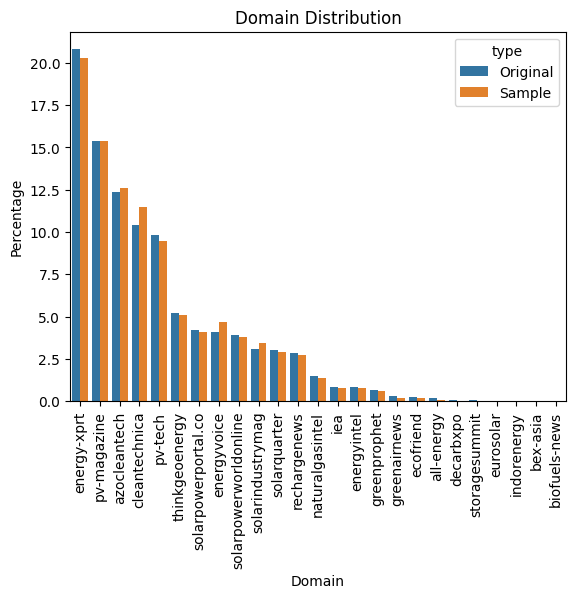

In [140]:
original_domain_counts = articles_df["domain"].value_counts().to_frame()
original_domain_counts = original_domain_counts / original_domain_counts.sum() * 100
domain_counts_df = original_domain_counts.copy()
domain_counts_df["type"] = "Original"


sample_domain_counts = sample_df_media_cleaned["domain"].value_counts().to_frame()
sample_domain_counts = sample_domain_counts / sample_domain_counts.sum() * 100
sample_domain_counts["type"] = "Sample"

domain_counts_df = pd.concat([domain_counts_df, sample_domain_counts])
sns.barplot(
    x=domain_counts_df.index,
    y=domain_counts_df["count"],
    hue=domain_counts_df["type"]
)
plt.title("Domain Distribution")
plt.xlabel("Domain")
plt.ylabel("Percentage")
plt.xticks(rotation=90)
plt.show()

### For Generated Patent Dataset

In [141]:
human_eval_df_patent.head()

,Unnamed: 0,question,answer,relevant_section,title,publication_date,inventor,category
0,0,What is the purpose of the cold accumulator ev...,"To supply cold to the cold storage, reducing t...",Distributed photovoltaic energy storage refrig...,Distributed photovoltaic energy storage refrig...,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Analytical & Explanatory Questions
1,1,What is the role of the refrigeration house co...,It is connected with the cold accumulation com...,Distributed photovoltaic energy storage refrig...,Distributed photovoltaic energy storage refrig...,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Government & Corporate Initiatives
2,2,What is the overall function of the distribute...,To convert solar energy into electric energy t...,Distributed photovoltaic energy storage refrig...,Distributed photovoltaic energy storage refrig...,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Sustainability & Technological Innovation Ques...
3,3,What is the purpose of the distributed photovo...,"The system supplies cold to the cold storage, ...",Distributed photovoltaic energy storage refrig...,Distributed photovoltaic energy storage refrig...,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Sustainability & Technological Innovation Ques...
4,4,What is the main function of the cold accumula...,The cold accumulation equipment stores cold en...,Distributed photovoltaic energy storage refrig...,Distributed photovoltaic energy storage refrig...,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Sustainability & Technological Innovation Ques...


In [142]:
eval_abstracts_df_patent = patents_df[
    patents_df["title"].str.lower().isin(human_eval_df_patent["title"].str.lower()) |
    patents_df["abstract"].str.lower().isin(human_eval_df_patent["relevant_section"].str.lower())
]
eval_abstracts_df_patent.head()

,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc_code,title_lang,abstract_lang,text,cleaned_text,topic
57170,CN-114558462-B,CN-202210285989-A,CN,Preparation method and application method of p...,The invention belongs to the technical field o...,2023-04-25,[],C02F2103/08,en,en,Preparation method and application method of p...,preparation method application method photothe...,6
74317,CN-218580607-U,CN-202222107350-U,CN,Water conservancy and hydropower engineering c...,The utility model relates to a hydraulic and h...,2023-03-07,"[REN LIQIANG, ZHAO YU, DAI LIJUN, Cao Jige, XI...",Y02E10/20,en,en,Water conservancy and hydropower engineering c...,water conservancy hydropower engineering const...,0
131054,CN-114777340-A,CN-202210508526-A,CN,Concentrating solar energy seasonal sand high-...,The invention relates to a light-concentrating...,2022-07-22,"[LIU ZHONGBING, HU MENGQI, ZHANG LING]",F24D3/02,en,en,Concentrating solar energy seasonal sand high-...,concentrating solar energy seasonal sand high-...,1
188053,CN-113775355-B,CN-202111218769-A,CN,Rock mass stable type supporting device for ro...,The invention discloses a rock mass stable typ...,2022-11-29,[],E21D21/0026,en,en,Rock mass stable type supporting device for ro...,rock mass stable type supporting device rock b...,0
188684,CN-113683242-B,CN-202110787033-A,CN,Utilize solar energy to realize source separat...,The invention provides a treatment system for ...,2022-11-25,[],Y02A40/20,en,en,Utilize solar energy to realize source separat...,utilize solar energy realize source separation...,6


In [143]:
sample_df_patent = do_stratification(patents_df, "topic", 1000, 69)
# if the articles are already in the subsample from the evaluation set, then we remove them, so we just want unique urls
sample_df_patent = sample_df_patent[~sample_df_patent["title"].isin(eval_abstracts_df_patent["title"]) & ~sample_df_patent["abstract"].isin(eval_abstracts_df_patent["abstract"])]
sample_df_patent = pd.concat([sample_df_patent, eval_abstracts_df_patent])
sample_df_patent.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1009 entries, 402510 to 403880
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   publication_number  1009 non-null   object        
 1   application_number  1009 non-null   object        
 2   country_code        1009 non-null   object        
 3   title               1009 non-null   object        
 4   abstract            1009 non-null   object        
 5   publication_date    1009 non-null   datetime64[ns]
 6   inventor            1009 non-null   object        
 7   cpc_code            1009 non-null   object        
 8   title_lang          1009 non-null   object        
 9   abstract_lang       1009 non-null   object        
 10  text                1009 non-null   object        
 11  cleaned_text        1009 non-null   object        
 12  topic               1009 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(11)
mem

In [144]:
domain_counts = sample_df_patent['topic'].value_counts()
print(domain_counts)

topic
0    174
1    127
6    113
8    112
2    107
4     93
3     91
7     77
5     67
9     48
Name: count, dtype: int64


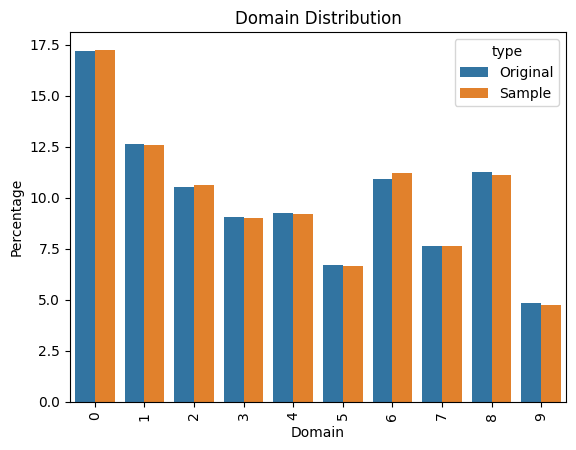

In [145]:
original_domain_counts = patents_df["topic"].value_counts().to_frame()
original_domain_counts = original_domain_counts / original_domain_counts.sum() * 100
domain_counts_df = original_domain_counts.copy()
domain_counts_df["type"] = "Original"


sample_domain_counts = sample_df_patent["topic"].value_counts().to_frame()
sample_domain_counts = sample_domain_counts / sample_domain_counts.sum() * 100
sample_domain_counts["type"] = "Sample"

domain_counts_df = pd.concat([domain_counts_df, sample_domain_counts])
sns.barplot(
    x=domain_counts_df.index,
    y=domain_counts_df["count"],
    hue=domain_counts_df["type"]
)
plt.title("Domain Distribution")
plt.xlabel("Domain")
plt.ylabel("Percentage")
plt.xticks(rotation=90)
plt.show()

### For Evaluated Patent QA pairs



In [146]:
human_eval_df_patent_cleaned.head()

,Unnamed: 0,relevant_section,question,answer,category,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
0,5,Distributed photovoltaic energy storage refrig...,How does the system reduce the cost of cold st...,The system reduces the cost of cold storage by...,Sustainability & Technological Innovation Ques...,5.0,The question can be answered based on the give...,4.0,"The question is concise and to the point, dire...",5.0,The question appears to be related to a genera...
1,10,Water path manifold structure of hydrogen ener...,What is good about the utility model?,The utility model has a simple structure that ...,Analytical & Explanatory Questions,5.0,"The question ""What is good about the utility m...",3.0,"The question is very short and to the point, b...",5.0,The question seems to be asking about a genera...
2,29,Active power control method of water-fire-wind...,What is the purpose of using power supply with...,The power supply with better regulation perfor...,Government & Corporate Initiatives,5.0,The question is clearly answerable by understa...,3.0,The question is directly related to power supp...,5.0,The question assumes knowledge of power suppli...
3,48,Water conservancy and hydropower engineering c...,What is the water conservancy and hydropower e...,The utility model discloses a water conservanc...,Sustainability & Technological Innovation Ques...,5.0,The question is clearly answerable with the gi...,3.0,The question seems to be about a specific tech...,5.0,The question contains technical terms and a sp...
4,61,Medium-and-long-term electric power quantity b...,What is the main consideration for the balanci...,The seasonal characteristics of renewable ener...,Analytical & Explanatory Questions,4.0,The context provides a detailed description of...,4.0,The question is asking about a specific aspect...,5.0,The question does not provide a specific conte...


In [147]:
eval_abstracts_df_patent_cleaned = patents_df[
    patents_df["abstract"].str.lower().isin(human_eval_df_patent_cleaned["relevant_section"].str.lower())
]
eval_abstracts_df_patent_cleaned.head()

,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc_code,title_lang,abstract_lang,text,cleaned_text,topic


In [148]:
sample_df_patent_cleaned = do_stratification(patents_df, "topic", 1000, 69)
# if the articles are already in the subsample from the evaluation set, then we remove them, so we just want unique urls
sample_df_patent_cleaned = sample_df_patent_cleaned[~sample_df_patent_cleaned["title"].isin(eval_abstracts_df_patent_cleaned["title"]) & ~sample_df_patent["abstract"].isin(eval_abstracts_df_patent_cleaned["abstract"])]
sample_df_patent_cleaned = pd.concat([sample_df_patent_cleaned, eval_abstracts_df_patent_cleaned])
sample_df_patent_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 994 entries, 402510 to 393853
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   publication_number  994 non-null    object        
 1   application_number  994 non-null    object        
 2   country_code        994 non-null    object        
 3   title               994 non-null    object        
 4   abstract            994 non-null    object        
 5   publication_date    994 non-null    datetime64[ns]
 6   inventor            994 non-null    object        
 7   cpc_code            994 non-null    object        
 8   title_lang          994 non-null    object        
 9   abstract_lang       994 non-null    object        
 10  text                994 non-null    object        
 11  cleaned_text        994 non-null    object        
 12  topic               994 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(11)
memo

In [149]:
domain_counts = sample_df_patent_cleaned['topic'].value_counts()
print(domain_counts)

topic
0    171
1    126
8    112
6    108
2    105
4     92
3     90
7     76
5     66
9     48
Name: count, dtype: int64


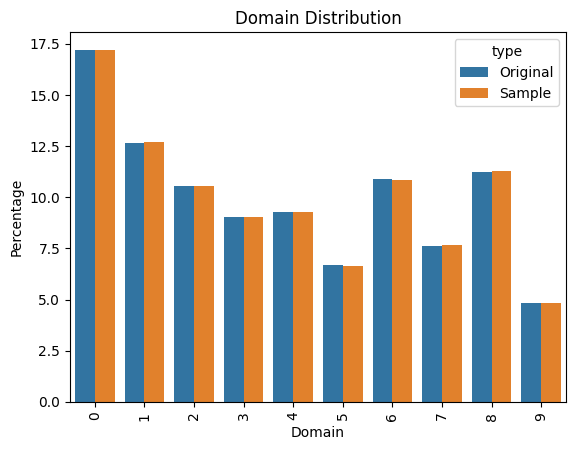

In [150]:
original_domain_counts = patents_df["topic"].value_counts().to_frame()
original_domain_counts = original_domain_counts / original_domain_counts.sum() * 100
domain_counts_df = original_domain_counts.copy()
domain_counts_df["type"] = "Original"


sample_domain_counts = sample_df_patent_cleaned["topic"].value_counts().to_frame()
sample_domain_counts = sample_domain_counts / sample_domain_counts.sum() * 100
sample_domain_counts["type"] = "Sample"

domain_counts_df = pd.concat([domain_counts_df, sample_domain_counts])
sns.barplot(
    x=domain_counts_df.index,
    y=domain_counts_df["count"],
    hue=domain_counts_df["type"]
)
plt.title("Domain Distribution")
plt.xlabel("Domain")
plt.ylabel("Percentage")
plt.xticks(rotation=90)
plt.show()

## Chunking

Chunking is a crucial step in the RAG pipeline. It involves breaking down the articles into smaller, more manageable pieces.

![chunking](https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F92c70184-ba0f-4877-9a55-e4add0e311ad_870x1116.gif)

There are mainly two reasons for this:
- **Generation:** The LLM has a limit on the number of tokens it can process at once. By chunking the articles, we can ensure that the LLM can generate responses without running into this limit. Another reason to use chunks for the generation step is to avoid "distractions" from irrelevant parts of the article. Just like if you were given a book and asked to answer a question about a the book it would be easier if you were just given the relevant chapter.
- **Retrieval:** Just like the LLM, the embedding model in the retrieval step has a limit on the number of tokens it can process at once. By chunking the articles, we can ensure that the embedding model can process the entire article. By chunking the articles, we can also improve the retrieval performance by having fine-grained chunks that can be matched more closely to the user query, rather then more general chunks.

Let's start by getting a better feeling for the most common size of chunks based on the number of characters

In [151]:
def get_lorem_text(num_chars: int) -> str:
    expected_avg_word_len = 3 # on the lower side to be safe
    text = lorem.words(num_chars // expected_avg_word_len)
    return text[:num_chars]

In [152]:
print(wrap_text(get_lorem_text(256)))

temporibus corrupti deleniti voluptatibus facere neque architecto libero cumque quasi voluptate
vitae eaque vel soluta explicabo pariatur excepturi aperiam est provident id quos a velit dolorem
beatae distinctio laboriosam adipisci numquam consequatur aute


In [153]:
print(wrap_text(get_lorem_text(512)))

facilis repudiandae et error quis sunt similique fuga beatae doloribus est omnis minus facere
officia id animi provident sapiente quibusdam iure earum nemo dolorem cupiditate eaque nesciunt
quae tempora eveniet vero rem perferendis enim nisi iusto ab voluptate eos exercitationem assumenda
aut vel obcaecati architecto odio voluptas tenetur magni a rerum libero debitis ipsum porro
consequatur eius tempore dignissimos distinctio harum deserunt accusantium illum corrupti ea
consequuntur recusandae nihil natus a


In [154]:
print(wrap_text(get_lorem_text(1024)))

impedit eos sequi fugiat voluptatem nisi perferendis dolorem labore corrupti quidem amet odio natus
modi recusandae consequuntur cupiditate voluptates vel laudantium consectetur dicta error quas
optio nemo incidunt iusto mollitia neque porro aspernatur nulla non ipsam similique tempora sit
facere delectus accusantium reprehenderit dolores qui suscipit eveniet quam commodi doloribus
repudiandae aut inventore eum molestiae omnis est exercitationem asperiores quia ea excepturi sed
tenetur ab maiores magnam fuga ullam numquam temporibus adipisci assumenda tempore necessitatibus
ratione eligendi quis libero in ipsa obcaecati ipsum debitis deserunt odit vitae vero hic
voluptatibus laboriosam consequatur veniam iste at sapiente fugit eaque rem blanditiis itaque
quaerat rerum laborum cum quae expedita illo beatae repellat ducimus nam nobis saepe cumque sint
nesciunt pariatur ad distinctio perspiciatis reiciendis ex iure veritatis explicabo enim aperiam
quos culpa dolore possimus maxime dolor d

In [155]:
print(wrap_text(get_lorem_text(2048)))

rem assumenda ipsam vel natus modi aliquam ut veniam necessitatibus voluptatem similique fuga
recusandae eius consequuntur ad rerum autem sint magni non officia voluptas adipisci consectetur
obcaecati quia doloribus voluptatibus optio iste laborum doloremque nemo eveniet suscipit minima
fugit quaerat impedit iusto dignissimos voluptate soluta est ab illum explicabo alias earum harum
praesentium ratione repellendus cum quos nam corporis hic aspernatur vero totam excepturi nihil eos
accusantium numquam unde ipsa dolorem aut nobis ea id distinctio qui labore quisquam vitae eum
neque cumque saepe nostrum repellat ex beatae commodi nisi quibusdam ipsum tempora laboriosam eaque
mollitia sapiente atque porro incidunt placeat laudantium a molestiae pariatur voluptatum enim
maxime odio blanditiis ullam voluptates minus in quidem quod dicta quis ducimus perferendis
perspiciatis officiis eligendi error iure facere sunt amet deleniti provident exercitationem animi
dolore culpa omnis accusamus quae

### Creating the Chunks

In this notebook we will be using two different chunking strategies:
- **Recursive Chunking:** This strategy involves recursively splitting the article into smaller chunks based on the article structure such as paragraphs and sentences until the chunk size is less than or equal to the maximum chunk size.
- **Semantic Chunking:** This strategy involves splitting the article into chunks based on semantic boundaries. This strategy finds boundaries between sentences that are semantically different and splits the article at these boundaries to create chunks. To do this we will need to use an embedding model to calculate the similarity between sentences. These embedding models will then also be used in the retrieval step to find the most relevant chunks.

To see how different texts get chunked with different strategies and chunk sizes check out the [Chunking Visualizer](https://chunkviz.up.railway.app/).

In [156]:
def get_recursive_splitter(chunk_size: int, chunk_overlap: int) -> TextSplitter:
    return RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", "(?<=\. )", " ", ""],
        length_function=len,
    )

In [157]:
# the recursive splitter mainly relies on newlines, are there even any? No, so it will focus on sentences.
sample_df["article"].map(lambda x: x.count("\n")).sum()

0

In [158]:
sample_df_media["article"].map(lambda x: x.count(".")).sum()

50986

In [159]:
sample_df_media_cleaned["article"].map(lambda x: x.count(".")).sum()

50615

In [160]:
sample_df_patent["abstract"].map(lambda x: x.count(".")).sum()

2505

In [161]:
sample_df_patent_cleaned["abstract"].map(lambda x: x.count(".")).sum()

2464

Let us set the device for efficient use of available resources.

In [162]:
# if we can make use of any device that is better than the CPU, we will use it
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

model_kwargs = {'device': device, "trust_remote_code": True}
model_kwargs

{'device': 'cuda', 'trust_remote_code': True}

We select three embedding models from HuggingFace to represent our text fragments in numerical forma in a vector space.

In [163]:
embedding_models = {
    "mini": HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2", model_kwargs=model_kwargs),
    "bge-m3": HuggingFaceEmbeddings(model_name="BAAI/bge-m3", model_kwargs=model_kwargs),
    "gte": HuggingFaceEmbeddings(model_name="Alibaba-NLP/gte-base-en-v1.5", model_kwargs=model_kwargs),
}

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/72.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/59.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/547M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

We also define the chunking strategies to be used. The recursive splittering is characterized by the length of chunks and the overlap between adjacent chunks. For the semantic chunking, sentences embedded as dense vectors are merged as long as the cosine distance between two consecutive sentences does not exceed a percentile based threshold.

In [ ]:
recursive_256_splitter = get_recursive_splitter(256, 64)
recursive_1024_splitter = get_recursive_splitter(1024, 128)
semantic_splitter = SemanticChunker(
    embedding_models["gte"], breakpoint_threshold_type="percentile"
)
splitters = {
    "recursive_256": recursive_256_splitter,
    "recursive_1024": recursive_1024_splitter,
    "semantic": semantic_splitter
}

In [ ]:
from typing import Dict, List, Tuple

def chunk_documents(df: pd.DataFrame, text_splitter) -> Tuple[List[Document],]:
    chunks = []
    id = 0

    for _, row in tqdm(df.iterrows(), total=len(df)):
        # Determine which text fields to use
        if 'article' in df.columns:
            content = row['article']
            title = row.get('title', '')
            full_text = f"{title}: {content}"
            metadata = {
                'title': title,
                'url': row.get('url', ''),
                'domain': row.get('domain', ''),
            }
        elif 'abstract' in df.columns:
            content = row['abstract']
            title = row.get('title', '')
            full_text = f"{title}: {content}"
            metadata = {
                'title': title,
                'topic': row.get('topic', ''),
            }
        else:
            continue  # Skip rows that don't have expected fields

        char_chunks = text_splitter.split_text(full_text)
        for chunk in char_chunks:
            id += 1
            chunk_metadata = metadata.copy()
            chunk_metadata['id'] = id
            chunks.append(Document(
                page_content=chunk,
                metadata=chunk_metadata,
            ))

    return chunks


In [ ]:
chunks_folder = silver_folder / "chunks"
if not chunks_folder.exists():
    chunks_folder.mkdir()

The following function will load existing chunks, prepared for our tutorial to speed up the preparation process.  

In [ ]:
def get_or_create_chunks(df: pd.DataFrame, text_splitter: TextSplitter, splitter_name: str) -> List[Document]:
    chunks_file = chunks_folder / f"{splitter_name}_chunks.json"
    if chunks_file.exists():
        with open(chunks_file, "r") as file:
            chunks = [Document(**chunk) for chunk in json.load(file)]
        print(f"Loaded {len(chunks)} chunks from {chunks_file}")
    else:
        chunks = chunk_documents(df, text_splitter)
        with open(chunks_file, "w") as file:
            json.dump([doc.dict() for doc in chunks], file, indent=4)
        print(f"Saved {len(chunks)} chunks to {chunks_file}")
    return chunks

In [ ]:
chunks = {}
for splitter_name, splitter in splitters.items():
    chunks[splitter_name] = get_or_create_chunks(sample_df, splitter, splitter_name)
    chunks[splitter_name+ "_media"] = get_or_create_chunks(sample_df_media, splitter, splitter_name + "_media")
    # chunks[splitter_name] = get_or_create_chunks(sample_df_media_cleaned, splitter, splitter_name + "_media_cleaned")
    chunks[splitter_name+ "_patent"] = get_or_create_chunks(sample_df_patent, splitter, splitter_name + "_patent")
    # chunks[splitter_name] = get_or_create_chunks(sample_df_patent_cleaned, splitter, splitter_name + "_patent_cleaned")

Now that we have created and saved the chunks we can analyze them. We can already see above that the semantic chunks are generally larger than the recursive chunks.

### Analyzing the Chunks

Let's start by looking at the first chunk of the first article to get a feeling for what the chunks look like depending on the chunking strategy and then we will look at the distribution of the chunk sizes and the number of chunks per article.

In [ ]:
for splitter_name, splitter_chunks in chunks.items():
    print(f"{splitter_name} chunks:")
    print(wrap_text(splitter_chunks[0].page_content, char_per_line=150))
    print()

In [ ]:
def plot_chunk_lengths(chunks: List[Document], title: str):
    sns.histplot([len(chunk.page_content) for chunk in chunks], kde=True)
    plt.title(title)
    plt.xlabel("Chunk length (characters)")
    plt.ylabel("Number of chunks")
    median_chunk_len = np.median([len(chunk.page_content) for chunk in chunks])
    mean_chunk_len = np.mean([len(chunk.page_content) for chunk in chunks])
    plt.axvline(median_chunk_len, color='r', linestyle='--', label=f"Median chunk length: {median_chunk_len:.2f}")
    plt.axvline(mean_chunk_len, color='g', linestyle='--', label=f"Mean chunk length: {mean_chunk_len:.2f}")
    plt.legend()
    plt.show()

In [ ]:
plot_chunk_lengths(chunks["recursive_256"], "Chunk lengths for recursive 256 splitter")

In [ ]:
plot_chunk_lengths(chunks["recursive_256_media"], "Chunk lengths for recursive 256 splitter")

In [ ]:
plot_chunk_lengths(chunks["recursive_256_patent"], "Chunk lengths for recursive 256 splitter")

In [ ]:
plot_chunk_lengths(chunks["recursive_1024"], "Chunk lengths for recursive 1024 splitter")

In [ ]:
plot_chunk_lengths(chunks["recursive_1024_media"], "Chunk lengths for recursive 1024 splitter")

In [ ]:
plot_chunk_lengths(chunks["recursive_1024_patent"], "Chunk lengths for recursive 1024 splitter")

In [ ]:
chunks.keys()

In [ ]:
plot_chunk_lengths(chunks["semantic"], "Chunk lengths for semantic splitter")

In [ ]:
plot_chunk_lengths(chunks["semantic_media"], "Chunk lengths for semantic splitter")

In [ ]:
plot_chunk_lengths(chunks["semantic_patent"], "Chunk lengths for semantic splitter")

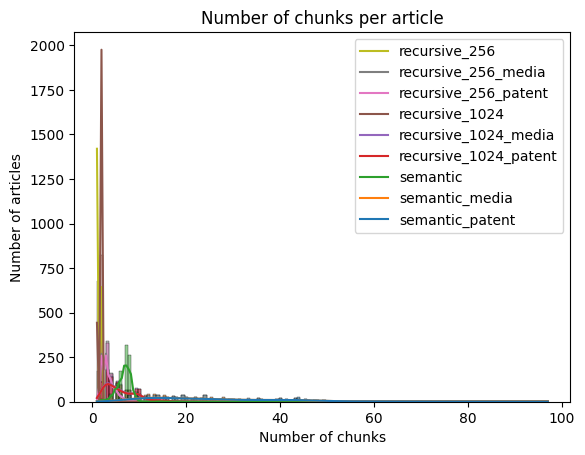

In [181]:
chunks_per_article = {splitter_name: Counter([chunk.metadata["title"] for chunk in chunks]) for splitter_name, chunks in chunks.items()}
counts = {splitter_name: [count for title, count in chunk_counts.items()] for splitter_name, chunk_counts in chunks_per_article.items()}

sns.histplot(counts, kde=True)
plt.title("Number of chunks per article")
plt.xlabel("Number of chunks")
plt.ylabel("Number of articles")
plt.legend(chunks_per_article.keys())
plt.show()

From our analysis of our created chunks we can see that the recursive chunks are all around the same size, close to the defined maximum. On the other hand, the semantic chunks vary in size. This is because the semantic chunking strategy is based on the semantic boundaries of the article.

We can also see that despite the semantic chunks being larger, the distribution of the number of chunks per article is much wider for the recursive chunks. This is because the recursive chunks are all around the same size, while the semantic chunks have many smaller ones and a few larger ones.

## Generating Embeddings

Now that we have clean chunks, the next step involves generating embeddings for our article chunks. These embeddings will serve as a crucial component for efficient retrieval within the RAG pipeline. For our vector store we'll utilize ChromaDB, a powerful tool for indexing and searching high-dimensional data. To integrate our chosen embedding models with ChromaDB, we'll define a custom wrapper class. This wrapper class will act as an intermediary, ensuring seamless communication between the models and the ChromaDB indexing system.

In [ ]:
class CustomChromadbEmbeddingFunction(EmbeddingFunction):

    def __init__(self, model) -> None:
        super().__init__()
        self.model = model

    def _embed(self, l):
        return [self.model.embed_query(x) for x in l]

    def embed_query(self, query):
        return self._embed([query])

    def __call__(self, input: Documents) -> Embeddings:
        embeddings = self._embed(input)
        return embeddings

We prepare three different embedding models in this tutorial.

In [ ]:
chroma_embedding_functions = {
    "mini": CustomChromadbEmbeddingFunction(embedding_models["mini"]),
    "bge-m3": CustomChromadbEmbeddingFunction(embedding_models["bge-m3"]),
    "gte": CustomChromadbEmbeddingFunction(embedding_models["gte"]),
}
for name, embedding_function in chroma_embedding_functions.items():
    sample = embedding_function(["Hello, world!"])[0][:5]
    print(f"{name} embedding sample: {sample}")

Generating embeddings can be a computationally intensive process. To optimize efficiency and avoid redundant computations, we'll leverage checkpointing. This technique involves storing the generated embeddings along with their corresponding article chunks. We'll define a simple class to encapsulate this data, facilitating efficient retrieval and reducing the need for recalculating embeddings unless absolutely necessary.

In [ ]:
embeddings_folder = silver_folder / "embeddings"
if not embeddings_folder.exists():
    embeddings_folder.mkdir()

In [ ]:
class DocumentEmbedding():
    def __init__(self, document: Document, text_embedding: List[float]) -> None:
        self.document = document
        self.text_embedding = text_embedding

    def to_dict(self) -> Dict:
        return {
            "document": self.document.dict(),
            "text_embedding": self.text_embedding
        }

    @classmethod
    def from_dict(cls, d: Dict) -> "DocumentEmbedding":
        return cls(
            document=Document(**d["document"]),
            text_embedding=d["text_embedding"]
        )


def get_or_create_embeddings(
        embedding_function: EmbeddingFunction,
        chunks: List[Document],
        embedding_name: str,
) -> List[DocumentEmbedding]:
    embeddings_file = embeddings_folder / f"{embedding_name}_embeddings.json"
    if embeddings_file.exists():
        with open(embeddings_file, "r") as file:
            embeddings = [DocumentEmbedding.from_dict(embedding) for embedding in json.load(file)]
        print(f"Loaded {len(embeddings)} embeddings from {embeddings_file}")
    else:
        embeddings = []
        for chunk in tqdm(chunks):
            text_embedding = embedding_function([chunk.page_content])[0]
            embedding = DocumentEmbedding(
                document=chunk,
                text_embedding=text_embedding
            )
            embeddings.append(embedding)
        with open(embeddings_file, "w") as file:
            json.dump([embedding.to_dict() for embedding in embeddings], file, indent=4)
        print(f"Saved {len(embeddings)} embeddings to {embeddings_file}")
    return embeddings

In [ ]:
embeddings = {}
for embedding_name, embedding_function in chroma_embedding_functions.items():
    for splitter_name, splitter_chunks in chunks.items():
        print(f"Generating embeddings for {embedding_name} with {splitter_name} splitter")
        embeddings[f"{embedding_name}_{splitter_name}"] = get_or_create_embeddings(
            embedding_function, splitter_chunks, f"{embedding_name}_{splitter_name}"
        )

The number of embeddings relates to the number of chunks produced by the individual chunking strategies, not the embedding dimensions. Thus smaller chunk size (e.g. 256) yields more chunks than larger chunk size (1024), and semantic embeddings even less chunks.

## Storing the Embeddings in ChromaDB

As mentioned above for our semantic search retrieval we will be storing the embeddings in ChromaDB. ChromaDB is a powerful tool for indexing and searching high-dimensional data. It is allows e.g. to use approximate nearest neighbor (ANN) search based on the Hierarchical Navigable Small World (HNSW) algorithm, which is known for its efficiency in searching high-dimensional spaces.

Just like with normal SQL databases we have a server, in this case an SQLite server, that we can connect to with a client. We will then use the client to connect to the server and create for each set of embeddings a new seperate database which can be thought of as the index or a vector space. ChromaDB calls these separate vector spaces "collections". These collections will then be used to search for the most relevant chunks to a user query.

![semantic search](https://images.contentstack.io/v3/assets/bltefdd0b53724fa2ce/bltf137a833984d3581/63728faba32209106e8b0b72/vector-search-diagram.png)

In [ ]:
gold_folder = data_folder / "gold"
if not gold_folder.exists():
    gold_folder.mkdir()
chromadb_folder = gold_folder / "chromadb"
if not chromadb_folder.exists():
    chromadb_folder.mkdir()

chroma_client = chromadb.PersistentClient(path=chromadb_folder.as_posix())

In [ ]:
from pathlib import Path
import shutil
from google.colab import files

# Path to the folder you want to zip
data_folder = Path("/content/data")

# Create zip file (this will be /content/data.zip)
zip_path = shutil.make_archive(str(data_folder), 'zip', root_dir=str(data_folder))

# Download the zip file
files.download(zip_path)


Again we can make use of preprocessed data as before to speed up the preparatory steps.

In [ ]:
def get_or_create_collection(
        name: str,
        embedding_function: EmbeddingFunction,
        embeddings: List[DocumentEmbedding],
        batch_size: int = 128
) -> Collection:

    collection = chroma_client.get_or_create_collection(
        name=name,
        # configure to use cosine distance not default L2
        metadata={"hnsw:space": "cosine"},
        embedding_function=embedding_function
    )

    if collection.count() == 0:
        for i in tqdm(range(0, len(embeddings), batch_size)):
            batch = embeddings[i:i+batch_size]
            collection.add(
                documents=[embedding.document.page_content for embedding in batch],
                embeddings=[embedding.text_embedding for embedding in batch],
                ids=[str(embedding.document.metadata["id"]) for embedding in batch],
                metadatas=[embedding.document.metadata for embedding in batch]
            )

    return collection

In [ ]:
collections = {}
for collection_name, current_embeddings in embeddings.items():
    collection = get_or_create_collection(
        collection_name,
        chroma_embedding_functions[collection_name.split("_")[0]],
        current_embeddings
    )
    collections[collection_name] = collection
    print(f"Collection {collection_name} has {collection.count()} documents")

The above printout shows the three embedding models applied to the three chunking strategies.

Once we have stored all the embeddings in ChromaDB we can test the retrieval process by querying one of our collections and see what the most similar chunks are. Try some different queries and see what the most similar chunks are and whether they make sense.

##To change

In [ ]:
selected_collection = collections["mini_recursive_256"]
results = selected_collection.query(
    query_texts=["Climate Change"],
    n_results=3,
)
for doc in results["documents"][0]:
    print(wrap_text(doc))
    print()

In [ ]:
selected_collection_media = collections["mini_recursive_256_media"]
results = selected_collection_media.query(
    query_texts=["Climate Change"],
    n_results=3,
)
for doc in results["documents"][0]:
    print(wrap_text(doc))
    print()

In [ ]:
selected_collection_patent = collections["mini_recursive_256_patent"]
results = selected_collection_patent.query(
    query_texts=["Climate Change"],
    n_results=3,
)
for doc in results["documents"][0]:
    print(wrap_text(doc))
    print()

In [ ]:
# selected_collection = collections["gte_recursive_1024"]
# results = selected_collection.query(
#     query_texts=["Climate Change"],
#     n_results=3,
# )
# for doc in results["documents"][0]:
#     print(wrap_text(doc))
#     print()

## Analyzing the Embedding Space

To gain a better understandign of how the retrieval process works we will analyze the embedding space. We will start by projecting the embeddings into a 2D space using UMAP. UMAP is a dimensionality reduction technique that is particularly well-suited for visualizing high-dimensional data in a lower-dimensional space. The most notable advantages over other dimensionality reduction techniques are increased speed and better preservation of the data's global structure. We will then use the UMAP embeddings to create a scatter plot of the chunks.

In [ ]:
def get_vectors_from_collection(collection: Collection):
    stored_chunks = collection.get(include=["documents", "metadatas", "embeddings"])
    return np.array(stored_chunks["embeddings"])

def get_vectors_by_domain(collection: Collection, domain: str):
    stored_chunks = collection.get(include=["documents", "metadatas", "embeddings"])
    metadatas = stored_chunks["metadatas"]
    indices = [str(metadata["id"]) for metadata in metadatas if metadata["topic"] == domain or metadata["domain"] == domain]
    return collection.get(include=["embeddings"], ids=indices)["embeddings"]

def fit_umap(vectors: np.ndarray):
    return umap.UMAP().fit(vectors)

def project_embeddings(embeddings, umap_transform):
    return umap_transform.transform(embeddings)

In [ ]:
vectors = get_vectors_from_collection(selected_collection)
print(f"Original shape: {vectors.shape}")
umap_transform = fit_umap(vectors)
vectors_projections = project_embeddings(vectors, umap_transform)
print(f"Projected shape: {vectors_projections.sshape}")

The dimensions above show how the chunked embeddings with 768 dimensions are reduced to two dimensions for visualization purposes.

You can zoom in the plot by clicking and dragging a box around the area you want to zoom in on. You can also reset the plot by double clicking on the plot.

In [ ]:
fig = px.scatter(x=vectors_projections[:, 0], y=vectors_projections[:, 1])
fig.show(renderer="colab")

Next we will color the embeddings by the domain of the article to see if there are any patterns or clusters in the embedding space based on the domain.

In [ ]:
fig = go.Figure()
for domain in sample_df["domain"].unique():
    domain_vectors = get_vectors_by_domain(selected_collection, domain)
    domain_projections = project_embeddings(domain_vectors, umap_transform)
    fig.add_trace(go.Scatter(x=domain_projections[:, 0], y=domain_projections[:, 1], mode='markers', marker=dict(size=4), name=domain))

fig.show(renderer="colab")

We can also visualize the retrieval process by plotting the query and the most similar chunks in the embedding space. This will give us a better understanding of how the retrieval process works and how the most similar chunks are found.

Note that the UMAP projection uses a metric approach which differs from the approximate nearest neighbor approach used for retrieval. Also don't forget that the embeddings are in a high-dimensional space and we are only visualizing a 2D projection of them so the distances between the points might not be accurate. Try some different queries and see how the most similar chunks are found.

In [ ]:
def plot_retrieval_results(
        query: str,
        selected_collection: Collection,
        n_results: int = 5
):
    vectors = get_vectors_from_collection(selected_collection)
    umap_transform = fit_umap(vectors)
    vectors_projections = project_embeddings(vectors, umap_transform)

    query_embedding = selected_collection._embedding_function([query])[0]
    query_embedding = np.array(query_embedding).reshape(1, -1)
    query_projection = project_embeddings(query_embedding, umap_transform)

    nearest_neighbors = selected_collection.query(
        query_texts=[query],
        n_results=n_results,
    )
    neighbor_vectors = selected_collection.get(include=["embeddings"], ids=nearest_neighbors["ids"][0])["embeddings"]
    neighbor_projections = project_embeddings(neighbor_vectors, umap_transform)


    fig = go.Figure()

    fig.add_trace(go.Scatter(x=vectors_projections[:, 0], y=vectors_projections[:, 1], mode='markers', marker=dict(size=5), name="other vectors"))
    fig.add_trace(go.Scatter(x=neighbor_projections[:, 0], y=neighbor_projections[:, 1], mode='markers', marker=dict(size=5, color='orange'), name="nearest neighbors"))
    fig.add_trace(go.Scatter(x=query_projection[:, 0], y=query_projection[:, 1], mode='markers', marker=dict(size=10, color='red', symbol='x'), name="query"))

    fig.show(renderer="colab")

In [ ]:
plot_retrieval_results(
    "Climate Change",
    selected_collection,
)

Lastly we will analyze the distribution of the cosine distances between the query and the different chunks. This will give us a better understanding of the cosine distance and show that the distances in the high-dimensional space are not the same as in the 2D projection. Do not confuse the cosine distance with the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). The cosine similarity is the cosine of the angle between two vectors and the cosine distance is 1 minus the cosine similarity so that smaller numbers mean the vectors are more similar.

In [ ]:
def cosine_distance(vector1, vector2):
    dot_product = np.dot(vector1, vector2.T)
    norm_product = np.linalg.norm(vector1) * np.linalg.norm(vector2)
    similarity = dot_product / norm_product
    return 1 - similarity

def plot_cosine_distances(
        query: str,
        selected_collection: Collection
):
    vectors = get_vectors_from_collection(selected_collection)
    umap_transform = fit_umap(vectors)
    vectors_projections = project_embeddings(vectors, umap_transform)

    query_embedding = selected_collection._embedding_function([query])[0]
    query_embedding = np.array(query_embedding).reshape(1, -1)
    query_projection = project_embeddings(query_embedding, umap_transform)

    similarities = np.array([cosine_distance(query_embedding, vector) for vector in vectors])

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=vectors_projections[:, 0],
        y=vectors_projections[:, 1],
        mode='markers',
        marker=dict(
            size=5,
            color=similarities.flatten(),
            colorscale='RdBu',
            colorbar=dict(title='Cosine Distance')
        ),
        text=['Cosine Distance: {:.4f}'.format(
            sim) for sim in similarities.flatten()],
        name='Other Vectors'
    ))

    fig.add_trace(go.Scatter(x=[query_projection[0][0]], y=[
                query_projection[0][1]], mode='markers', marker=dict(size=10, color='black', symbol='x'), text=['Query Vector'], name='Query Vector'))

    fig.show(renderer="colab")

In [ ]:
plot_cosine_distances(
    "Climate Change",
    selected_collection,
)

### For media all

In [ ]:
selected_collection = selected_collection_media

In [ ]:
vectors = get_vectors_from_collection(selected_collection)
print(f"Original shape: {vectors.shape}")
umap_transform = fit_umap(vectors)
vectors_projections = project_embeddings(vectors, umap_transform)
print(f"Projected shape: {vectors_projections.shape}")

In [ ]:
fig = px.scatter(x=vectors_projections[:, 0], y=vectors_projections[:, 1])
fig.show(renderer="colab")

In [ ]:
fig = go.Figure()
for domain in sample_df_media["domain"].unique():
    domain_vectors = get_vectors_by_domain(selected_collection, domain)
    domain_projections = project_embeddings(domain_vectors, umap_transform)
    fig.add_trace(go.Scatter(x=domain_projections[:, 0], y=domain_projections[:, 1], mode='markers', marker=dict(size=4), name=domain))

fig.show(renderer="colab")

In [ ]:
plot_retrieval_results(
    "Climate Change",
    selected_collection,
)

In [ ]:
plot_cosine_distances(
    "Climate Change",
    selected_collection,
)

### For patent all

In [ ]:
selected_collection = selected_collection_patent

In [ ]:
vectors = get_vectors_from_collection(selected_collection)
print(f"Original shape: {vectors.shape}")
umap_transform = fit_umap(vectors)
vectors_projections = project_embeddings(vectors, umap_transform)
print(f"Projected shape: {vectors_projections.shape}")

In [ ]:
fig = px.scatter(x=vectors_projections[:, 0], y=vectors_projections[:, 1])
fig.show(renderer="colab")

In [ ]:
fig = go.Figure()
for domain in sample_df_patent["topic"].unique():
    domain_vectors = get_vectors_by_domain(selected_collection, domain)
    domain_projections = project_embeddings(domain_vectors, umap_transform)
    # Convert the domain to a string before passing it as the 'name'
    fig.add_trace(go.Scatter(x=domain_projections[:, 0], y=domain_projections[:, 1], mode='markers', marker=dict(size=4), name=str(domain)))

fig.show(renderer="colab")

In [ ]:
plot_retrieval_results(
    "Climate Change",
    selected_collection,
)

In [ ]:
plot_cosine_distances(
    "Climate Change",
    selected_collection,
)

## Putting it all Together

Now that we have generated the embeddings and stored them in ChromaDB we can put it all together and create the RAG pipeline. The RAG pipeline consists of the following steps:
- **Indexing:** The first step is the preperation we have already done. We have chunked the articles and generated embeddings for the chunks and stored them in ChromaDB, our vector store/index.
- **Retrieval:** The next step in the RAG pipeline is to retrieve the most relevant chunks to the user query. This is done by querying the ChromaDB index with the user query and retrieving the most similar chunks.
- **Generation:** The next step is to generate a response to the user query. This is done by feeding the retrieved chunks and the user query to the LLM and generating a response.

### How does Langchain work?

In this notebook we will be using [Langchain](https://www.langchain.com/) to build up our pipeline. You do not need a library like Langchain or [LlamaIndex](https://www.llamaindex.ai/) to build a RAG pipeline, but it can make the process easier.

The idea of Langchain and its LCEL (Langchain Expression Language) is very simple. Within the pipeline there are lots of steps that take an input and produce an output. These steps can be chained together to form a pipeline. The LCEL is a simple language that allows you to define these steps and how they are connected. For more technical details on how Langchain works check out the [Langchain Documentation](https://python.langchain.com/v0.1/docs/expression_language/).

In simple terms langchain provides an abstraction of a step that has an `invoke` method that takes an input, a dictionary of parameters and returns an output also a dictionary. This allows you to chain together different steps and define how they are connected and also split of chains of steps into separate pipelines.

Below you can see an overview of our RAG pipeline:

![rag_pipeline](https://miro.medium.com/v2/resize:fit:1400/0*XE_XZ3QrRhlB3b_q.png)

And now let's look at the implementation of the RAG pipeline.

In [ ]:
def create_qa_chain(retriever: BaseRetriever):
    template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. \
    If you don't know the answer, just say that you don't know. Keep the answer concise.

    Question: {question}
    Context: {context}
    Answer:
    """
    rag_prompt = ChatPromptTemplate.from_template(template)

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    rag_chain = RunnableParallel(
        {
            "context": retriever,
            "question": RunnablePassthrough()
        }
    ).assign(answer=(
         RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
            | rag_prompt
            | llm
            | StrOutputParser()
    ))

    return rag_chain

For Langchain to work with our ChromaDB collections we need to transform the collections into a format that Langchain can work with so called stores and retrievers.

In [ ]:
def collection_to_store(collection_name: str, lc_embedding_model: EmbeddingFunction):
    return Chroma(
        client=chroma_client,
        collection_name=collection_name,
        embedding_function=lc_embedding_model,
    )

def store_to_retriever(store: VectorStore, k: int = 3):
    retriever = store.as_retriever(
        search_type="similarity", search_kwargs={'k': k}
    )
    return retriever

##To check

## To Change

In [ ]:
# selected_store = collection_to_store("gte_recursive_1024", embedding_models["gte"])
# selected_retriever = store_to_retriever(selected_store)
# selected_retriever.invoke("Climate Change")

In [ ]:
selected_store = collection_to_store("mini_recursive_256", embedding_models["mini"])
selected_retriever = store_to_retriever(selected_store)
selected_retriever.invoke("Climate Change")

Now that we have our retriever we can create our RAG pipeline. Try some different queries and see how the pipeline responds.

In [ ]:
selected_chain = create_qa_chain(selected_retriever)
selected_chain.invoke("Where are the biggest increases in wildfire smoke exposure in recent years?")

In [ ]:
selected_store = collection_to_store("mini_recursive_256_media", embedding_models["mini"])
selected_retriever = store_to_retriever(selected_store)
selected_retriever.invoke("Climate Change")

In [ ]:
selected_chain = create_qa_chain(selected_retriever)
selected_chain.invoke("Where are the biggest increases in wildfire smoke exposure in recent years?")

In [ ]:
selected_store = collection_to_store("mini_recursive_256_patent", embedding_models["mini"])
selected_retriever = store_to_retriever(selected_store)
selected_retriever.invoke("Climate Change")

In [ ]:
selected_chain = create_qa_chain(selected_retriever)
selected_chain.invoke("How does the system reduce the cost of cold storage?")

In [ ]:
chains = {}
for collection_name, collection in collections.items():
    store = collection_to_store(collection_name, embedding_models[collection_name.split("_")[0]])
    retriever = store_to_retriever(store)
    chain = create_qa_chain(retriever)
    chains[collection_name] = chain

chains.keys()

## Evaluation

Because we have many hyperparameters such as chunk size, prompts etc. to tune and different strategies to try we will use the [RAGAS (RAG Assesment) framework](https://docs.ragas.io/en/stable/) to evaluate our pipeline. RAGAS is a framework that allows you to evaluate your RAG pipeline with an LLM as a judge and other metrics that also utilize embedding models. We will go more into detail on the metrics later on.

Before we can start the evaluation we need to define the evaluation questions and their ground truth answers. For this we will use the provided evaluation questions. To increase our question pool we will also generate some additional question and answer pairs based on a random chunk and utilizing the LLM (GPT-4o) to generate the question and answer.

In [ ]:
human_eval_df.head()

In [ ]:
human_eval_df_media.head()

In [ ]:
human_eval_df_media_cleaned.head()

In [ ]:
human_eval_df_patent.head()

In [ ]:
human_eval_df_patent_cleaned.head()

As we are only given questions and the relevant sections of the articles we need to generate the answers to the questions. We will use the LLM (GPT-4o) to generate the answers to the questions.

In [ ]:
def generate_eval_answers(df: pd.DataFrame) -> pd.DataFrame:
    answer_geneation_prompt = """Answer the following question based on the article:
    Question: {question}
    Article: {article}
    """
    answer_generation_chain = ChatPromptTemplate.from_template(answer_geneation_prompt) | llm
    for i, row in tqdm(df.iterrows(), total=len(df)):
        df.at[i, "ground_truth"] = answer_generation_chain.invoke({"question": row["question"], "article": row["relevant_section"]}).content
    return df

In [ ]:
if (silver_folder / "human_eval.csv").exists():
    human_eval_df = pd.read_csv(silver_folder / "human_eval.csv")
else:
    human_eval_df = generate_eval_answers(human_eval_df)
    human_eval_df.to_csv(silver_folder / "human_eval.csv", index=False)

human_eval_df.head()


In [ ]:
if (silver_folder / "human_eval_media.csv").exists():
    human_eval_df_media = pd.read_csv(silver_folder / "human_eval_media.csv")
else:
    human_eval_df_media = generate_eval_answers(human_eval_df_media)
    human_eval_df_media.to_csv(silver_folder / "human_eval_media.csv", index=False)

human_eval_df_media.head()


In [ ]:
if (silver_folder / "human_eval_media_cleaned.csv").exists():
    human_eval_df_media_cleaned = pd.read_csv(silver_folder / "human_eval_media_cleaned.csv")
else:
    human_eval_df_media_cleaned = generate_eval_answers(human_eval_df_media_cleaned)
    human_eval_df_media_cleaned.to_csv(silver_folder / "human_eval_media_cleaned.csv", index=False)

human_eval_df_media_cleaned.head()


In [ ]:
if (silver_folder / "human_eval_patent.csv").exists():
    human_eval_df_patent = pd.read_csv(silver_folder / "human_eval_patent.csv")
else:
    human_eval_df_patent = generate_eval_answers(human_eval_df_patent)
    human_eval_df_patent.to_csv(silver_folder / "human_eval_patent.csv", index=False)

human_eval_df_patent.head()


In [ ]:
if (silver_folder / "human_eval_patent_cleaned.csv").exists():
    human_eval_df_patent_cleaned = pd.read_csv(silver_folder / "human_eval_patent_cleaned.csv")
else:
    human_eval_df_patent_cleaned = generate_eval_answers(human_eval_df_patent_cleaned)
    human_eval_df_patent_cleaned.to_csv(silver_folder / "human_eval_patent_cleaned.csv", index=False)

human_eval_df_patent_cleaned.head()


We will now generate some synthetic questions and answers based on random chunks. So we will give the LLM a random chunk and ask it to generate a question and answer based on the chunk.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
# !unzip /content/data-20250416T092408Z-001.zip -d /content/data/


In [ ]:
def generate_synthetic_qa_pairs(documents: List[Document], n: int = 10) -> List[str]:
    synthetic_questions = []
    documents = np.random.choice(documents, n)

    question_generation_prompt = """Generate a short and general question based on the following news article:
    Article: {article}
    """
    question_generation_chain = ChatPromptTemplate.from_template(question_generation_prompt) | llm

    answer_geneation_prompt = """Answer the following question based on the article:
    Question: {question}
    Article: {article}
    """
    answer_generation_chain = ChatPromptTemplate.from_template(answer_geneation_prompt) | llm


    for document in tqdm(documents):
        element = {}
        content = document.page_content
        element["relevant_section"] = content
        if "url" in document.metadata and document.metadata["url"]:
            element["url"] = document.metadata["url"]
        else:
            element["url"] = None
        question = question_generation_chain.invoke({"article": content}).content
        element["question"] = question
        answer = answer_generation_chain.invoke({"question": question, "article": content}).content
        element["ground_truth"] = answer
        synthetic_questions.append(element)

    return pd.DataFrame(synthetic_questions)

In [ ]:
if not (silver_folder / "synthetic_eval.csv").exists():
    synthetic_eval_df = generate_synthetic_qa_pairs(chunks["recursive_1024"], 25)
    synthetic_eval_df.to_csv(silver_folder / "synthetic_eval.csv", index=False)
else:
    synthetic_eval_df = pd.read_csv(silver_folder / "synthetic_eval.csv", index_col=0)
synthetic_eval_df.head()

In [ ]:
if not (silver_folder / "synthetic_media_eval.csv").exists():
    synthetic_eval_df_media = generate_synthetic_qa_pairs(chunks["recursive_1024_media"], 25)
    synthetic_eval_df_media.to_csv(silver_folder / "synthetic_media_eval.csv", index=False)
else:
    synthetic_eval_df_media = pd.read_csv(silver_folder / "synthetic_media_eval.csv", index_col=0)
synthetic_eval_df_media.head()

In [ ]:
if not (silver_folder / "synthetic_patent_eval.csv").exists():
    synthetic_eval_df_patent = generate_synthetic_qa_pairs(chunks["recursive_1024_patent"], 25)
    synthetic_eval_df_patent.to_csv(silver_folder / "synthetic_patent_eval.csv", index=False)
else:
    synthetic_eval_df_patent = pd.read_csv(silver_folder / "synthetic_patent_eval.csv", index_col=0)
synthetic_eval_df_patent.head()

In [ ]:
question_length = {
    "human": human_eval_df["question"].map(len),
    "synthetic": synthetic_eval_df["question"].map(len)
}

sns.histplot(question_length, kde=True)
plt.title("Question Length Distribution")
plt.xlabel("Question Length")
plt.ylabel("Count")
plt.show()

In [ ]:
eval_df = pd.concat([human_eval_df, synthetic_eval_df], ignore_index=True)
eval_df["is_synthetic"] = eval_df["relevant_section"].isna()
eval_df["is_synthetic"].value_counts()

In [ ]:
question_length = {
    "human": human_eval_df_media["question"].map(len),
    "synthetic": synthetic_eval_df_media["question"].map(len)
}

sns.histplot(question_length, kde=True)
plt.title("Question Length Distribution")
plt.xlabel("Question Length")
plt.ylabel("Count")
plt.show()

In [ ]:
eval_df_media = pd.concat([human_eval_df_media, synthetic_eval_df_media], ignore_index=True)
eval_df_media["is_synthetic"] = eval_df_media["relevant_section"].isna()
eval_df_media["is_synthetic"].value_counts()

In [ ]:
question_length = {
    "human": human_eval_df_patent["question"].map(len),
    "synthetic": synthetic_eval_df_patent["question"].map(len)
}

sns.histplot(question_length, kde=True)
plt.title("Question Length Distribution")
plt.xlabel("Question Length")
plt.ylabel("Count")
plt.show()

In [ ]:
eval_df_patent = pd.concat([human_eval_df_patent, synthetic_eval_df_patent], ignore_index=True)
eval_df_patent["is_synthetic"] = eval_df_patent["relevant_section"].isna()
eval_df_patent["is_synthetic"].value_counts()

Now we have doubled the number of questions and answers. However, we can see that our synthetic questions are slightly longer than the provided questions which could mean that they are slightly easier to answer. This potential bias should be taken into account when evaluating the pipeline.

### RAGAS Metrics

RAGAS provides a variety of metrics to evaluate the performance of a RAG pipeline. Here are some of the key metrics we will be using and how they are calculated:

- [Answer Relevancy](https://docs.ragas.io/en/stable/concepts/metrics/answer_relevance.html): This metric measures the relevance of the generated answer to the user query. The Answer Relevancy is defined as the mean cosine similartiy of the original question to a number of artifical questions, which where generated (reverse engineered) based on the answer.
- [Answer Correctness](https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html): This metric measures the correctness of the generated answer. Answer correctness encompasses two critical aspects: semantic similarity between the generated answer and the ground truth, as well as factual similarity. These aspects are combined using a weighted scheme to formulate the answer correctness score.
- [Faithfulness](https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html): This metric measures how well the generated answer is faithful to the retrieved chunks. The generated answer is regarded as faithful if all the claims that are made in the answer can be inferred from the given context. To calculate this a set of claims from the generated answer is first identified. Then each one of these claims are cross checked with given context to determine if it can be inferred from given context or not.
- [Context Relevancy](https://docs.ragas.io/en/stable/concepts/metrics/context_relevancy.html): This metric measures the relevance of the retrieved chunks to the user query. Ideally, the retrieved context should exclusively contain essential information to address the provided query. To compute this, we initially estimate the number of sentences within the retrieved context that are relevant for answering the given question and devide it by the total number of sentences in the retrieved context.

![ragas-metrics](https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fd3cfa382-3a0b-4424-b8c1-e0d4d4a1efec_1600x683.png)

For this to work we create a test dataset for each of our RAG pipelines that contains the evaluation questions and their ground truth answers. We then run all the questions through our RAG pipeline and store the generated answers and the retrieved chunks. We can then use this test dataset to calculate the RAGAS metrics.

In [ ]:
datasets_folder = gold_folder / "datasets"
if not datasets_folder.exists():
    datasets_folder.mkdir()

def get_or_create_eval_dataset(name: str, df: pd.DataFrame, chain: Chain) -> Dataset:
    dataset_file = datasets_folder/ f"{name}_dataset.json"
    if dataset_file.exists():
        with open(dataset_file, "r") as file:
            dataset = Dataset.from_dict(json.load(file))
        print(f"Loaded {name} dataset from {dataset_file}")
    else:
        datapoints = {
            "question": df["question"].tolist(),
            "answer": [],
            "contexts": [],
            "ground_truth": df["ground_truth"].tolist(),
            "context_urls": []
        }
        for question in tqdm(datapoints["question"]):
            result = chain.invoke(question)
            datapoints["answer"].append(result["answer"])
            datapoints["contexts"].append([str(doc.page_content) for doc in result["context"]])
            # Check if 'url' exists in doc.metadata before accessing it
            datapoints["context_urls"].append([doc.metadata.get("url", "") for doc in result["context"]])
        dataset = Dataset.from_dict(datapoints)
        with open(dataset_file, "w") as file:
            json.dump(dataset.to_dict(), file)
        print(f"Saved {name} dataset to {dataset_file}")
    return dataset

In [ ]:
results_folder = gold_folder / "results"
if not results_folder.exists():
    results_folder.mkdir()

def get_or_run_llm_eval(name: str, dataset: Dataset, llm_judge_model: LLM) -> pd.DataFrame:
    eval_results_file = results_folder / f"{name}_llm_eval_results.csv"
    if eval_results_file.exists():
        eval_results = pd.read_csv(eval_results_file)
        print(f"Loaded {name} evaluation results from {eval_results_file}")
    else:
        eval_results = evaluate(dataset,
                                metrics=[faithfulness, answer_relevancy, context_relevancy, answer_correctness],
                                is_async=True,
                                llm=llm_judge_model,
                                embeddings=embedding_models["gte"],
                                run_config=RunConfig(
                                    timeout=60, max_retries=10, max_wait=60, max_workers=8),
                                ).to_pandas()
        eval_results.to_csv(eval_results_file, index=False)
        print(f"Saved {name} evaluation results to {eval_results_file}")
    return eval_results

In [ ]:
def plot_llm_eval(name: str, eval_results: pd.DataFrame):
    # select only the float64 columns (assuming these are the RAGAS metrics)
    ragas_metrics_data = (eval_results
                        .select_dtypes(include=[np.float64]))


    # boxplot of distributions
    sns.boxplot(data=ragas_metrics_data, palette="Set2")
    plt.title(f'{name}: Distribution of RAGAS Evaluation Metrics')
    plt.ylabel('Scores')
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # barplot of means
    means = ragas_metrics_data.mean()
    plt.figure(figsize=(14, 8))
    sns.barplot(x=means.index, y=means, palette="Set2")
    plt.title(f'{name}: Mean of RAGAS Evaluation Metrics')
    plt.ylabel('Mean Scores')
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_multiple_evals(eval_results: Dict[str, pd.DataFrame]):
    # combine the results
    full_results = []
    for name, results in eval_results.items():
        results['name'] = name
        full_results.append(results)

    full_results = pd.concat(full_results, ignore_index=True)
    full_results = full_results.sort_values(by='name')


    # select only the float64 columns (assuming these are the RAGAS metrics)
    ragas_metrics_data = full_results.select_dtypes(include=[np.float64])
    ragas_metrics_data['name'] = full_results['name']

    # boxplot of distributions
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='variable', y='value', hue='name', data=pd.melt(ragas_metrics_data, id_vars='name'), palette="Set2")
    plt.title('Distribution of RAGAS Evaluation Metrics by Model')
    plt.ylabel('Scores')
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

    # barplot of means
    means = ragas_metrics_data.groupby('name').mean().reset_index()
    means_melted = pd.melt(means, id_vars='name')

    plt.figure(figsize=(14, 8))
    sns.barplot(x='variable', y='value', hue='name', data=means_melted, palette="Set2")
    plt.title('Mean of RAGAS Evaluation Metrics by Model')
    plt.ylabel('Mean Scores')
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

In [ ]:
selected_dataset = get_or_create_eval_dataset("selected", eval_df, selected_chain)

As a judge we use the GPT-4o-mini model. This model is a smaller version of the GPT-4o model. Whilst it is not as powerful as the full GPT-4o model it is still a very powerful model and can be used to evaluate the performance of our RAG pipeline without having to high costs.

It has also been suggest in Literature that when evaluating LLMs with LLMS as judges the evaluation is more reliable when the judge a different model than the model being evaluated. This is because the models might have learned to exploit the weaknesses of the other model or have a certain bias to there own answers.
https://arxiv.org/abs/2404.13076

In [ ]:
judge = ChatOpenAI(model="gpt-4o-mini")
question_prompt = ChatPromptTemplate.from_template(
    "Answer the following question: {question}")
question_chain = question_prompt | judge | StrOutputParser()
# Sample questions from eval_df
sample_questions = eval_df["question"].sample(5).tolist()
for question in sample_questions:
    try:
        response = question_chain.invoke({"question": question})
        print(f"Question: {question}\nResponse: {response}\n")
    except Exception as e:
        print(f"Error processing question: {question}\nError: {e}\n")

In [ ]:
selected_llm_eval_results = get_or_run_llm_eval("selected", selected_dataset, llm)
plot_llm_eval("selected", selected_llm_eval_results)

In [ ]:
datasets = {}
for name, chain in chains.items():
    datasets[name] = get_or_create_eval_dataset(name, eval_df, chain)

In [ ]:
llm_results = {}
for dataset_name, dataset in datasets.items():
    llm_results[dataset_name] = get_or_run_llm_eval(dataset_name, dataset, llm)

In [ ]:
plot_multiple_evals(llm_results)

In [ ]:
mean_scores = {}
for name, results in llm_results.items():
    mean_scores[name] = results.select_dtypes(include=[np.float64]).mean()

total_mean_scores = pd.DataFrame(mean_scores).mean()
total_mean_scores.sort_values(ascending=False)

From the evaluation we can see that the RAG pipeline using the GTE embedding model by alibaba or BGE-M3 model along with recursive chunking with a chunk size of 1024 have on average across the metrics the best performance. This is likely due to the fact that these embedding models are the most powerful and the recursive chunking with a chunk size of 1024 provides enough context to the LLM but not too much that it gets distracted.

In [ ]:
best_collection = collections["gte_recursive_1024"]
best_store = collection_to_store("gte_recursive_1024", embedding_models["gte"])

## Advanced Methods

In this final section we will look at some more advanced methods to improve our RAG pipeline and comparing them to our best performing pipeline.

### Multi-Querying

Multi-querying is a technique that involves querying the retrieval model with multiple questions to retrieve relevant chunks. This approach can enhance the retrieval process by leveraging the diversity of queries to capture a broader range of relevant information. By combining the results from multiple queries, we can potentially improve the quality of the retrieved chunks and, consequently, the generated responses. When creating these additional queries the goal is to create queries that are different from the original query but still relevant to the user's information need, i.e variations of the original query.

![multi-querying](https://miro.medium.com/v2/resize:fit:1400/1*wa27F8CbKqYtaRRGyRKy0Q.png)

In [ ]:
def generate_query_variations(query: str, num_additional_queries: int) -> List[str]:
    multiquery_prompt = """You are an assistant tasked with generating {num_queries} \
    different versions of the given user question to retrieve relevant documents from a vector \
    database. By generating multiple perspectives on the user question and breaking it down, your goal is to help \
    the user overcome some of the limitations of the distance-based similarity search. \
    Provide these alternative questions separated by newlines without any numbering or listing.
    Original question: {question}
    Alternatives:
    """

    multiquery_chain = ChatPromptTemplate.from_template(multiquery_prompt) | llm
    return multiquery_chain.invoke({"question": query, "num_queries": num_additional_queries}).content.split("\n")

In [ ]:
def plot_multiquery_retrieval_results(query: str, collection : Collection, num_additional_queries: int = 3, num_results: int = 3):
    vectors = get_vectors_from_collection(collection)
    umap_transform = fit_umap(vectors)
    vectors_projections = project_embeddings(vectors, umap_transform)

    query_projections = project_embeddings(collection._embedding_function([query]), umap_transform)

    query_variations = generate_query_variations(query, 5)
    query_variations_projections = project_embeddings(collection._embedding_function(query_variations), umap_transform)

    original_relevant_docs = collection.query(
        query_texts=[query],
        n_results=num_results,
    )
    original_relevant_docs_ids = [item for sublist in original_relevant_docs["ids"] for item in sublist] # flatten
    original_relevant_docs_embeddings = collection.get(include=["embeddings"], ids=original_relevant_docs_ids)["embeddings"]
    original_relevant_docs_projections = project_embeddings(original_relevant_docs_embeddings, umap_transform)

    additional_relevant_docs = collection.query(
        query_texts=query_variations,
        n_results=num_results,
    )
    additional_relevant_docs_ids = [item for sublist in additional_relevant_docs["ids"] for item in sublist] # flatten
    # remove duplicates
    additional_relevant_docs_ids = list(set(additional_relevant_docs_ids))
    # remove the original relevant docs from the additional relevant docs
    additional_relevant_docs_ids = [doc_id for doc_id in additional_relevant_docs_ids if doc_id not in original_relevant_docs_ids]
    additional_relevant_docs_embeddings = collection.get(include=["embeddings"], ids=additional_relevant_docs_ids)["embeddings"]
    additional_relevant_docs_projections = project_embeddings(additional_relevant_docs_embeddings, umap_transform)

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=vectors_projections[:, 0], y=vectors_projections[:, 1], mode='markers', marker=dict(size=5), name="other vectors"))
    fig.add_trace(go.Scatter(x=query_projections[:, 0], y=query_projections[:, 1], mode='markers', marker=dict(size=7, color='black', symbol='x'), name="original query"))
    fig.add_trace(go.Scatter(x=query_variations_projections[:, 0], y=query_variations_projections[:, 1], mode='markers', marker=dict(size=7, color='red', symbol='x'), name="query variations"))
    fig.add_trace(go.Scatter(x=original_relevant_docs_projections[:, 0], y=original_relevant_docs_projections[:, 1], mode='markers', marker=dict(size=7, color='orange'), name="original relevant docs"))
    fig.add_trace(go.Scatter(x=additional_relevant_docs_projections[:, 0], y=additional_relevant_docs_projections[:, 1], mode='markers', marker=dict(size=7, color='green'), name="additional relevant docs"))

    fig.show(renderer="colab")

In [ ]:
plot_multiquery_retrieval_results("Climate Change", selected_collection)

In [ ]:
class MultiQueryRetriever(BaseRetriever):
    store: VectorStore
    num_additional_queries: int = 3
    num_results: int = 3

    def _get_query_variations(self, query: str) -> List[str]:
       return generate_query_variations(query, self.num_additional_queries)

    def _get_relevant_documents(
        self, original_query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:
        queries = self._get_query_variations(original_query)
        queries.append(original_query)
        retriever = store_to_retriever(self.store, k=self.num_results)
        relevant_docs = []
        for query in queries:
            results = retriever.invoke(query, run_manager=run_manager)
            # remove duplicates
            for res in results:
                if res not in relevant_docs:
                    relevant_docs.append(res)
        return relevant_docs


In [ ]:
multiquery_retriever = MultiQueryRetriever(store=best_store, num_additional_queries=3, num_results=3)
multiquery_chain = create_qa_chain(multiquery_retriever)
multiquery_chain.invoke("Where are the biggest increases in wildfire smoke exposure in recent years?")

In [ ]:
datasets["multiquery"] = get_or_create_eval_dataset("multiquery", eval_df, multiquery_chain)

In [ ]:
llm_results["multiquery"] = get_or_run_llm_eval("multiquery", datasets["multiquery"], llm)

In [ ]:
strategy_results = {}
strategy_results["gte_recursive_1024"] = llm_results["gte_recursive_1024"]
strategy_results["multiquery"] = llm_results["multiquery"]
plot_multiple_evals(strategy_results)

We can see that on average the answer correctness does slightly increase when using multi-querying. This is likely due to the fact that the retrieval process is more robust and can capture a broader range of relevant information. However, the faithfullness and context_relevancy decrease could be due to the multi-querying introducing more noise into the retrieval process by retrieving more chunks in general and some of them being less relevant.

### HyDE - Hypothetical Document Embeddings

The idea of the HyDE method is to generate hypothetical documents that are similar to the user query and then retrieve the most similar chunks to these hypothetical documents. This can be useful when the user query is not very specific or when the user query is not very similar to the chunks. The HyDE method can be used to generate hypothetical documents that are more similar to the chunks and therefore improve the retrieval process. Another way to think about it is generating a hypothetical answer and therby reaching an area in the embedding space that is more similar to the actual answer which might not be reachable from the user query.

![hyde](https://miro.medium.com/v2/resize:fit:1200/1*vPX3TZXE5NQ0wHjrpI_muw.png)

In [ ]:
def generate_hypothetical_document(query: str, num_hypotheses: int) -> List[str]:
    hyde_prompt = """Please write a news passage about the topic.
    Topic: {query}
    Passage:
    """

    hyde_chain = ChatPromptTemplate.from_template(hyde_prompt) | llm
    hypothetical_documents = [hyde_chain.invoke({"query": query}).content for _ in range(num_hypotheses)]
    return hypothetical_documents

In [ ]:
def plot_hyde_retrieval_results(query: str, collection : Collection, num_hypo_documents: int = 2, num_results: int = 3):
    vectors = get_vectors_from_collection(collection)
    umap_transform = fit_umap(vectors)
    vectors_projections = project_embeddings(vectors, umap_transform)

    query_projections = project_embeddings(collection._embedding_function([query]), umap_transform)

    hypothetical_documents = generate_hypothetical_document(query, num_hypo_documents)
    query_variations_projections = project_embeddings(collection._embedding_function(hypothetical_documents), umap_transform)

    original_relevant_docs = collection.query(
        query_texts=[query],
        n_results=num_results,
    )
    original_relevant_docs_ids = [item for sublist in original_relevant_docs["ids"] for item in sublist] # flatten
    original_relevant_docs_embeddings = collection.get(include=["embeddings"], ids=original_relevant_docs_ids)["embeddings"]
    original_relevant_docs_projections = project_embeddings(original_relevant_docs_embeddings, umap_transform)

    additional_relevant_docs = collection.query(
        query_texts=hypothetical_documents,
        n_results=num_results,
    )
    additional_relevant_docs_ids = [item for sublist in additional_relevant_docs["ids"] for item in sublist] # flatten
    # remove duplicates
    additional_relevant_docs_ids = list(set(additional_relevant_docs_ids))
    # remove the original relevant docs from the additional relevant docs
    additional_relevant_docs_ids = [doc_id for doc_id in additional_relevant_docs_ids if doc_id not in original_relevant_docs_ids]
    additional_relevant_docs_embeddings = collection.get(include=["embeddings"], ids=additional_relevant_docs_ids)["embeddings"]
    additional_relevant_docs_projections = project_embeddings(additional_relevant_docs_embeddings, umap_transform)

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=vectors_projections[:, 0], y=vectors_projections[:, 1], mode='markers', marker=dict(size=5), name="other vectors"))
    fig.add_trace(go.Scatter(x=query_projections[:, 0], y=query_projections[:, 1], mode='markers', marker=dict(size=7, color='black', symbol='x'), name="original query"))
    fig.add_trace(go.Scatter(x=query_variations_projections[:, 0], y=query_variations_projections[:, 1], mode='markers', marker=dict(size=7, color='red', symbol='x'), name="hypothetical documents"))
    fig.add_trace(go.Scatter(x=original_relevant_docs_projections[:, 0], y=original_relevant_docs_projections[:, 1], mode='markers', marker=dict(size=7, color='orange'), name="original relevant docs"))
    fig.add_trace(go.Scatter(x=additional_relevant_docs_projections[:, 0], y=additional_relevant_docs_projections[:, 1], mode='markers', marker=dict(size=7, color='green'), name="additional relevant docs"))

    fig.show(renderer="colab")

In [ ]:
plot_hyde_retrieval_results("Climate Change", selected_collection)

In [ ]:
class HyDERetriever(BaseRetriever):
    store: VectorStore
    num_hypo_documents: int = 2
    num_results: int = 3

    def _get_hypothetical_documents(self, query: str) -> List[str]:
        return generate_hypothetical_document(query, self.num_hypo_documents)

    def _get_relevant_documents(
        self, original_query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:
        hypothetical_documents = self._get_hypothetical_documents(original_query)
        hypothetical_documents.append(original_query)
        retriever = store_to_retriever(self.store, k=self.num_results)
        relevant_docs = []
        for query in hypothetical_documents:
            results = retriever.invoke(query, run_manager=run_manager)
            # remove duplicates
            for res in results:
                if res not in relevant_docs:
                    relevant_docs.append(res)
        return relevant_docs


In [ ]:
hyde_retriever = HyDERetriever(store=best_store, k=3)
hyde_chain = create_qa_chain(hyde_retriever)
hyde_chain.invoke("Where are the biggest increases in wildfire smoke exposure in recent years?")

In [ ]:
datasets["hyde"] = get_or_create_eval_dataset("hyde", eval_df, hyde_chain)

In [ ]:
llm_results["hyde"] = get_or_run_llm_eval("hyde", datasets["hyde"], llm)

In [ ]:
strategy_results["hyde"] = llm_results["hyde"]
plot_multiple_evals(strategy_results)

Just like with multi-querying we can see that the answer correctness increases when using the HyDE method.

### Other Methods

There are many other methods that can be used to improve the RAG pipeline. Some of these include:
- [Step Back](https://arxiv.org/abs/2310.06117): Where the idea is to take a step back and understand the concepts and context of the user query and then use this information to retrieve the most relevant chunks.
- [Hybrid Search](https://medium.com/@zilliz_learn/hybrid-search-combining-text-and-image-for-enhanced-search-capabilities-3d3ce27de326): Where the idea is to not only use semantic search but also lexical search to retrieve the most relevant chunks and combine the results with a re-ranking step.

In [ ]:
os.system("jupyter nbconvert --to html --template pj cleantech_rag.ipynb")